# Import Libraries

In [6]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load Data

In [7]:
# Loading dataset
train_path =  "/content/train.csv"
test_path = "/content/test.csv"

# read train data and parse date_of_birth as date
train_df = pd.read_csv(train_path, parse_dates=['date_of_birth'])
test_df = pd.read_csv(test_path, parse_dates=['date_of_birth'])

# set 'id' as index
train_df = train_df.set_index('id')
test_df = test_df.set_index('id')

# Displaying the first few rows of each dataset to understand their structure
train_df_head = train_df.head()
test_df_head = test_df.head()

In [8]:
train_df_head

,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
id,,,,,,,,,,,,
1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0
2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0
3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0
4,1953-01-07,1,0.009141,0.353779,2100,2,4,0,0,573,829,0
5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0


In [9]:
test_df_head

,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2
id,,,,,,,,,,,
14,1980-05-15,0,0.001010,0.289556,2000,6,0,1,0,837,518
24,1967-06-09,0,0.032225,0.368951,2600,5,2,0,0,731,656
83,1946-09-07,0,0.019998,0.265779,2200,4,0,0,0,644,784
104,1991-07-25,2,0.052280,0.415845,2100,3,2,0,0,573,686
127,1948-09-17,0,0.070865,0.193792,2000,4,1,0,1,777,747


# Data preparation

In [10]:
# Calculating age from 'date_of_birth'
def calculate_age(born): # Function to calculate age from date_of_birth
    today = datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
train_df['age'] = train_df['date_of_birth'].apply(calculate_age)
test_df['age'] = test_df['date_of_birth'].apply(calculate_age)

# Dropping 'date_of_birth' as 'age' is more relevant
train_df.drop('date_of_birth', axis=1, inplace=True)
test_df.drop('date_of_birth', axis=1, inplace=True)

In [11]:
# Checking for missing values in both datasets
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

In [12]:
missing_values_train

number_dependants           0
credit_utilization          0
debt_to_income_ratio        0
monthly_income              0
number_open_credit_lines    0
number_open_loans           0
number_90_days_past_due     0
number_charged_off          0
score1                      0
score2                      0
target                      0
age                         0
dtype: int64

In [13]:
missing_values_test

number_dependants           0
credit_utilization          0
debt_to_income_ratio        0
monthly_income              0
number_open_credit_lines    0
number_open_loans           0
number_90_days_past_due     0
number_charged_off          0
score1                      0
score2                      0
age                         0
dtype: int64

No missing values

In [14]:
# Descriptive statistics to understand the distribution of variables
train_stats = train_df.describe()

In [15]:
train_stats

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
count,20839.000000,2.083900e+04,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.000000,20839.00000,20839.000000,20839.000000
mean,0.483421,4.815929e-02,0.333507,2290.772110,4.997745,2.027497,0.098901,0.098901,669.511637,669.29440,0.102164,59.299343
std,0.719653,4.571744e-02,0.117332,320.090288,2.248021,1.431671,0.314963,0.315420,98.005767,98.60763,0.302871,20.577121
min,-1.000000,3.932283e-07,0.029386,2000.000000,0.000000,0.000000,0.000000,0.000000,500.000000,500.00000,0.000000,24.000000
25%,0.000000,1.436676e-02,0.247782,2100.000000,3.000000,1.000000,0.000000,0.000000,584.000000,583.00000,0.000000,41.000000
50%,0.000000,3.478343e-02,0.325432,2200.000000,5.000000,2.000000,0.000000,0.000000,669.000000,670.00000,0.000000,59.000000
75%,1.000000,6.789546e-02,0.411210,2400.000000,6.000000,3.000000,0.000000,0.000000,755.000000,754.00000,0.000000,77.000000
max,6.000000,5.387018e-01,0.801838,5000.000000,15.000000,9.000000,3.000000,3.000000,839.000000,839.00000,1.000000,194.000000


Train data: there are about 21k unique customers.   
For each feature and target variable:
*   number_dependants: -1 to 6; **-1 should modify**; discrete variables;
*   credit_utilization: 0 to 0.5387; continous variables;
*   debt_to_income_ratio: 0.03 to 0.80; continous variables;
*   monthly_income: 2000 to 5000; increments of 100;
*   number_open_credit_lines: 0 to 15; discrete variables;
*   number_open_loans: 0 to 9; discrete variables;
*   number_90_days_past_due	& number_charged_off: 0 to 3; discrete variables;
*   score1 & score2: 500 to 839; continous variables;
*   age: 24 to 194; **older age need to check**;
*   target: 10% are default, imbalance dataset;

# Data Preprocessing and EDA

## Handling abnormal values

In [16]:
# number_dependants
'''
From common sense, number_dependants should be nonnegative numbers.
So value -1 maybe placeholder or data entry error. Additioanal, it takes 1% of data.
'''
print(f"There are {round(train_df[train_df['number_dependants'] == -1].shape[0]/train_df.shape[0] * 100, 2)} % records where 'number_dependants' is -1.")
# Correcting negative values in 'number_dependants' by replace with 0
train_df['number_dependants'] = train_df['number_dependants'].apply(lambda x: max(x, 0))
test_df['number_dependants'] = test_df['number_dependants'].apply(lambda x: max(x, 0))

# age
'''
Oldest person to ever live is 122 years old, and average US average is 38 from 2019 census.
Thus, I will replace age older than 122 with average age 38.
'''
print(f"There are {train_df[train_df['age'] > 122].shape[0]} records where age is larger than 122.")
train_df['age'] = train_df['age'].apply(lambda x: 38 if x >= 122 else x)
test_df['age'] = test_df['age'].apply(lambda x: 38 if x >= 122 else x)


There are 1.0 % records where 'number_dependants' is -1.
There are 7 records where age is larger than 122.


## Outliers

In [17]:
# Detecting outliers using the IQR method
features = train_df.columns.drop(['target'])
Q1 = train_df[features].quantile(0.25)
Q3 = train_df[features].quantile(0.75)
IQR = Q3 - Q1

# Defining outliers as those features that are beyond 1.5*IQR from the Q1 or Q3
outlier_condition = (train_df[features] < (Q1 - 1.5 * IQR)) | (train_df[features] > (Q3 + 1.5 * IQR))

In [18]:
np.round((outlier_condition.sum()/train_df.shape[0]) * 100, 2)

number_dependants           1.40
credit_utilization          4.27
debt_to_income_ratio        0.57
monthly_income              6.68
number_open_credit_lines    1.46
number_open_loans           0.45
number_90_days_past_due     9.40
number_charged_off          9.39
score1                      0.00
score2                      0.00
age                         0.00
dtype: float64

monthly_income, number_90_days_past_due, number_charged_off have many outliers.

## Distribution Plots

In [19]:
# Draw countplot for discrete variables
def dis_countplot(data, discrete_columns):
  # Create a figure to hold the subplots
  plt.figure(figsize=(20, 10))

  # Plot bar charts for discrete variables
  for i, column in enumerate(discrete_columns):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=column, data=data)
    plt.title(f'Count of {column}')
    plt.tight_layout()

# Draw histograms and KDE plots for continous variables
def con_histograms(data, continuous_columns):
  # Create a figure to hold the subplots
  plt.figure(figsize=(20, 10))

  # Plot histograms for continuous variables
  for i, column in enumerate(continuous_columns):
    if column == 'age':
      bins = 10
    else:
      bins = 'auto'
    plt.subplot(2, 3, i+1)
    sns.histplot(data[column], kde=True, bins=bins)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

# Plot for target variable with percentage
def target_dist(data, target_column):
  # Calculate the counts and the percentage for each category in the target variable
  target_counts = data[target_column].value_counts(normalize=True) * 100

  # Create the bar chart for the target variable
  plt.figure(figsize=(8, 6))
  ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette='coolwarm')

  # Annotate the bars with the percentage of each category
  for p in ax.patches:
      ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                  textcoords='offset points')
  plt.title('Distribution of Target Variable with Percentages')
  plt.xlabel('Target Category')
  plt.ylabel('Percentage')
  plt.tight_layout()

In [20]:
# Define discrete, continous, and target variables
discrete_columns = ['number_dependants', 'number_open_credit_lines', 'number_open_loans', 'number_90_days_past_due', 'number_charged_off']
continuous_columns = ['credit_utilization', 'debt_to_income_ratio', 'monthly_income', 'score1', 'score2', 'age']
target_column = 'target'

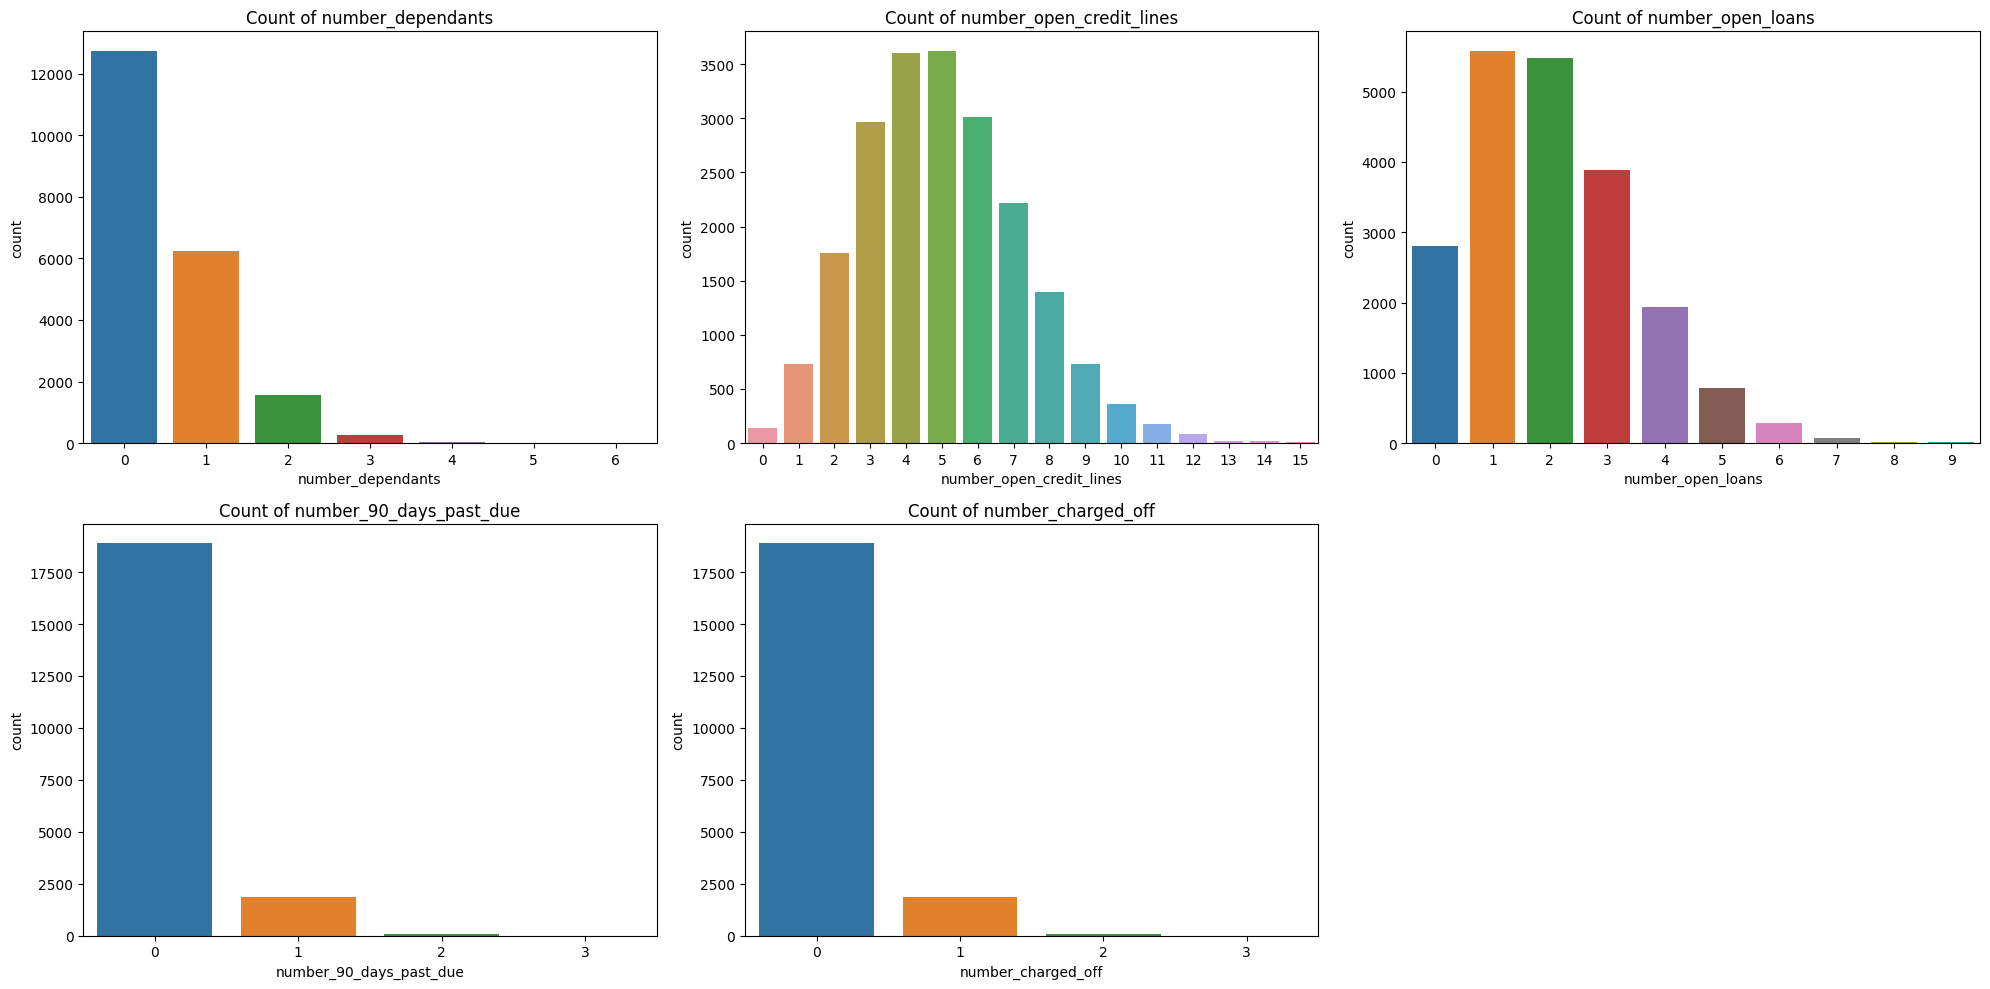

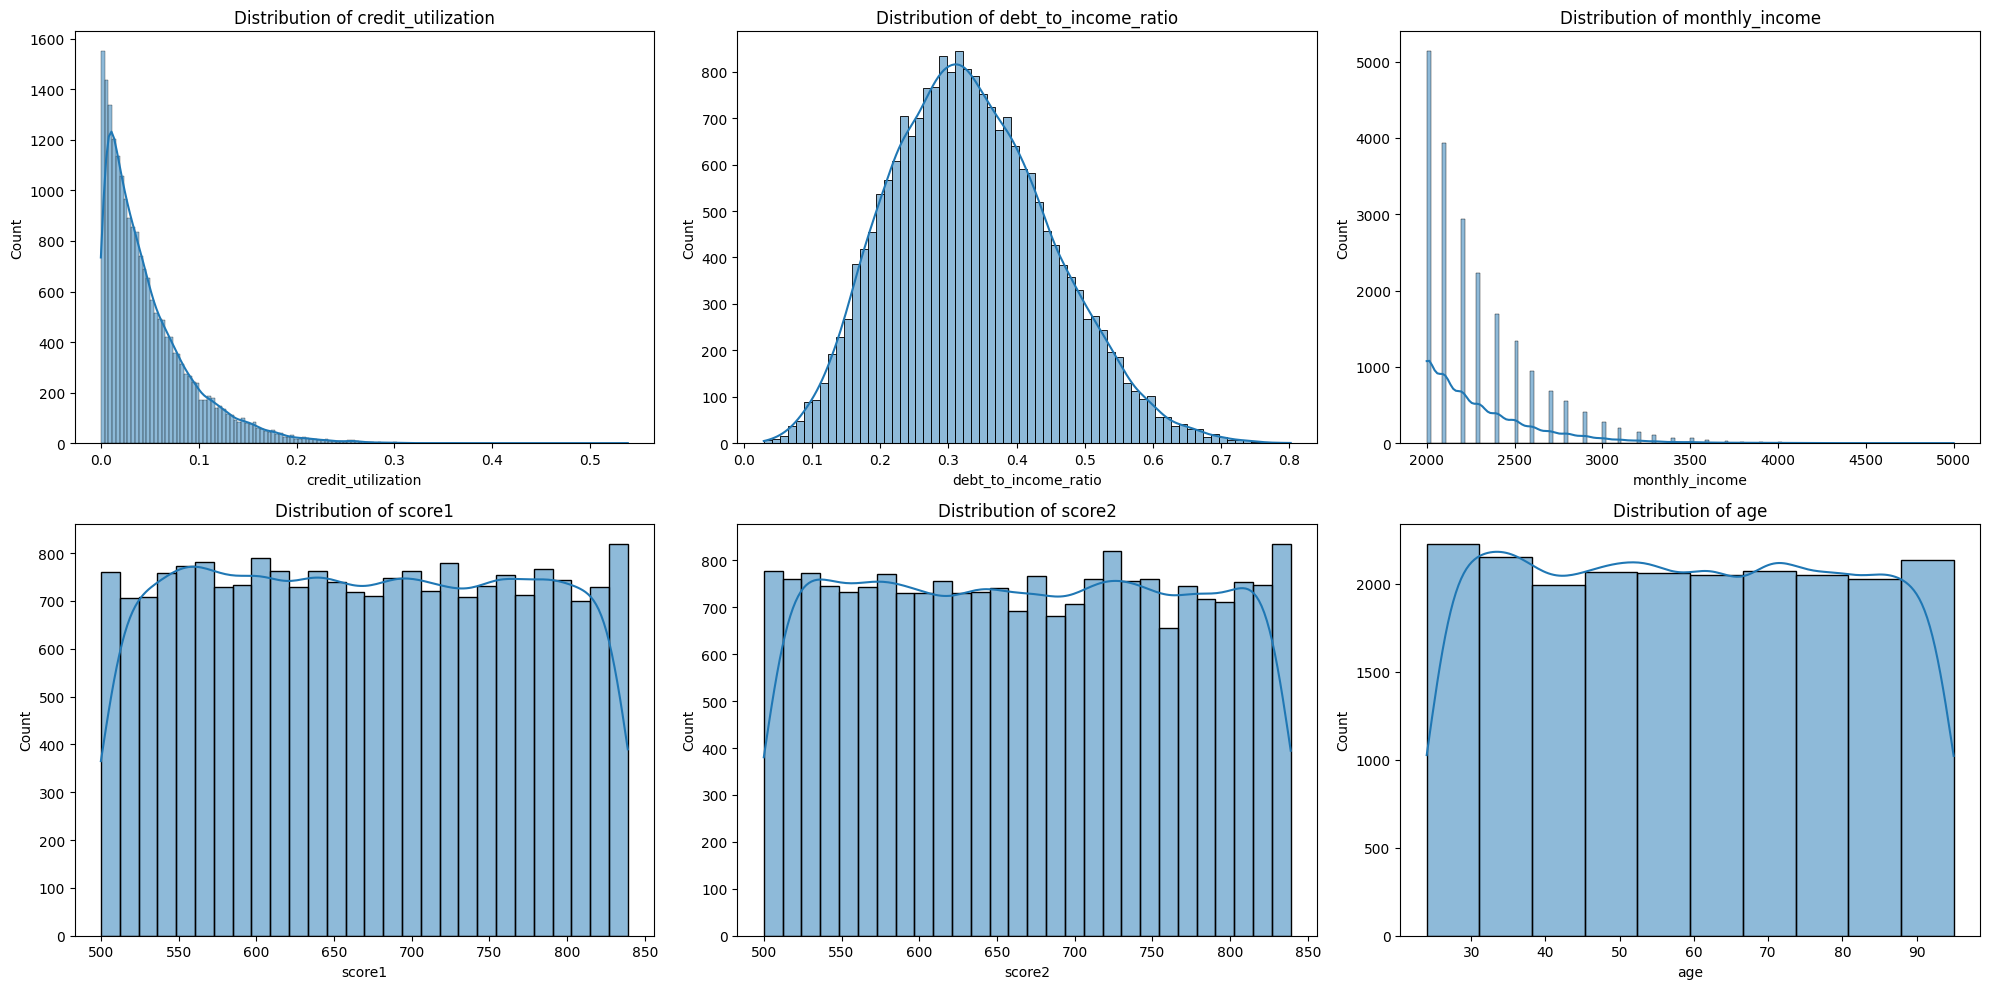

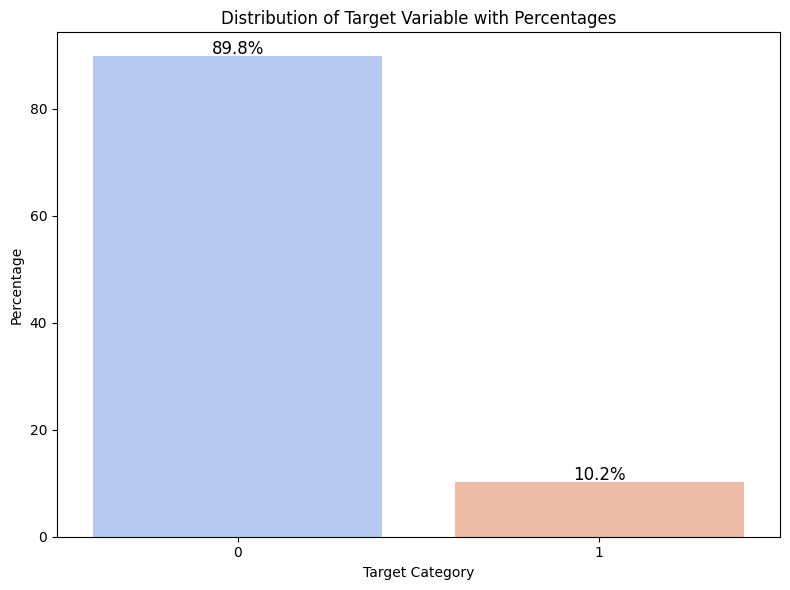

In [21]:
# Draw for train dataset
dis_countplot(train_df, discrete_columns)
con_histograms(train_df, continuous_columns)
target_dist(train_df, target_column)
plt.show()

*   number_dependants: majority of customers has 0 or 1 dependants.
*   number_open_credit_lines: approximate normal distribution. The majority customers has 2 to 7 open credit lines.
*   number_open_loans: right skewed, and the majority customers has 1 or 2 open loans.
*   number_90_days_past_due	& number_charged_off: majority customers never past 90 days due and never charged off.
*   credit_utilization: right skewed; majority customers credit uttilization is below 0.1.
*   debt_to_income_ratio: approximate normal distribution. The mean is around 0.3.
*   monthly_income: right skewed. majority customers income is below $2500.
*   score1 & score2: approximate uniform distribution.
*   age: approximate uniform distribution.
*   target: 10% are default, imbalance dataset.

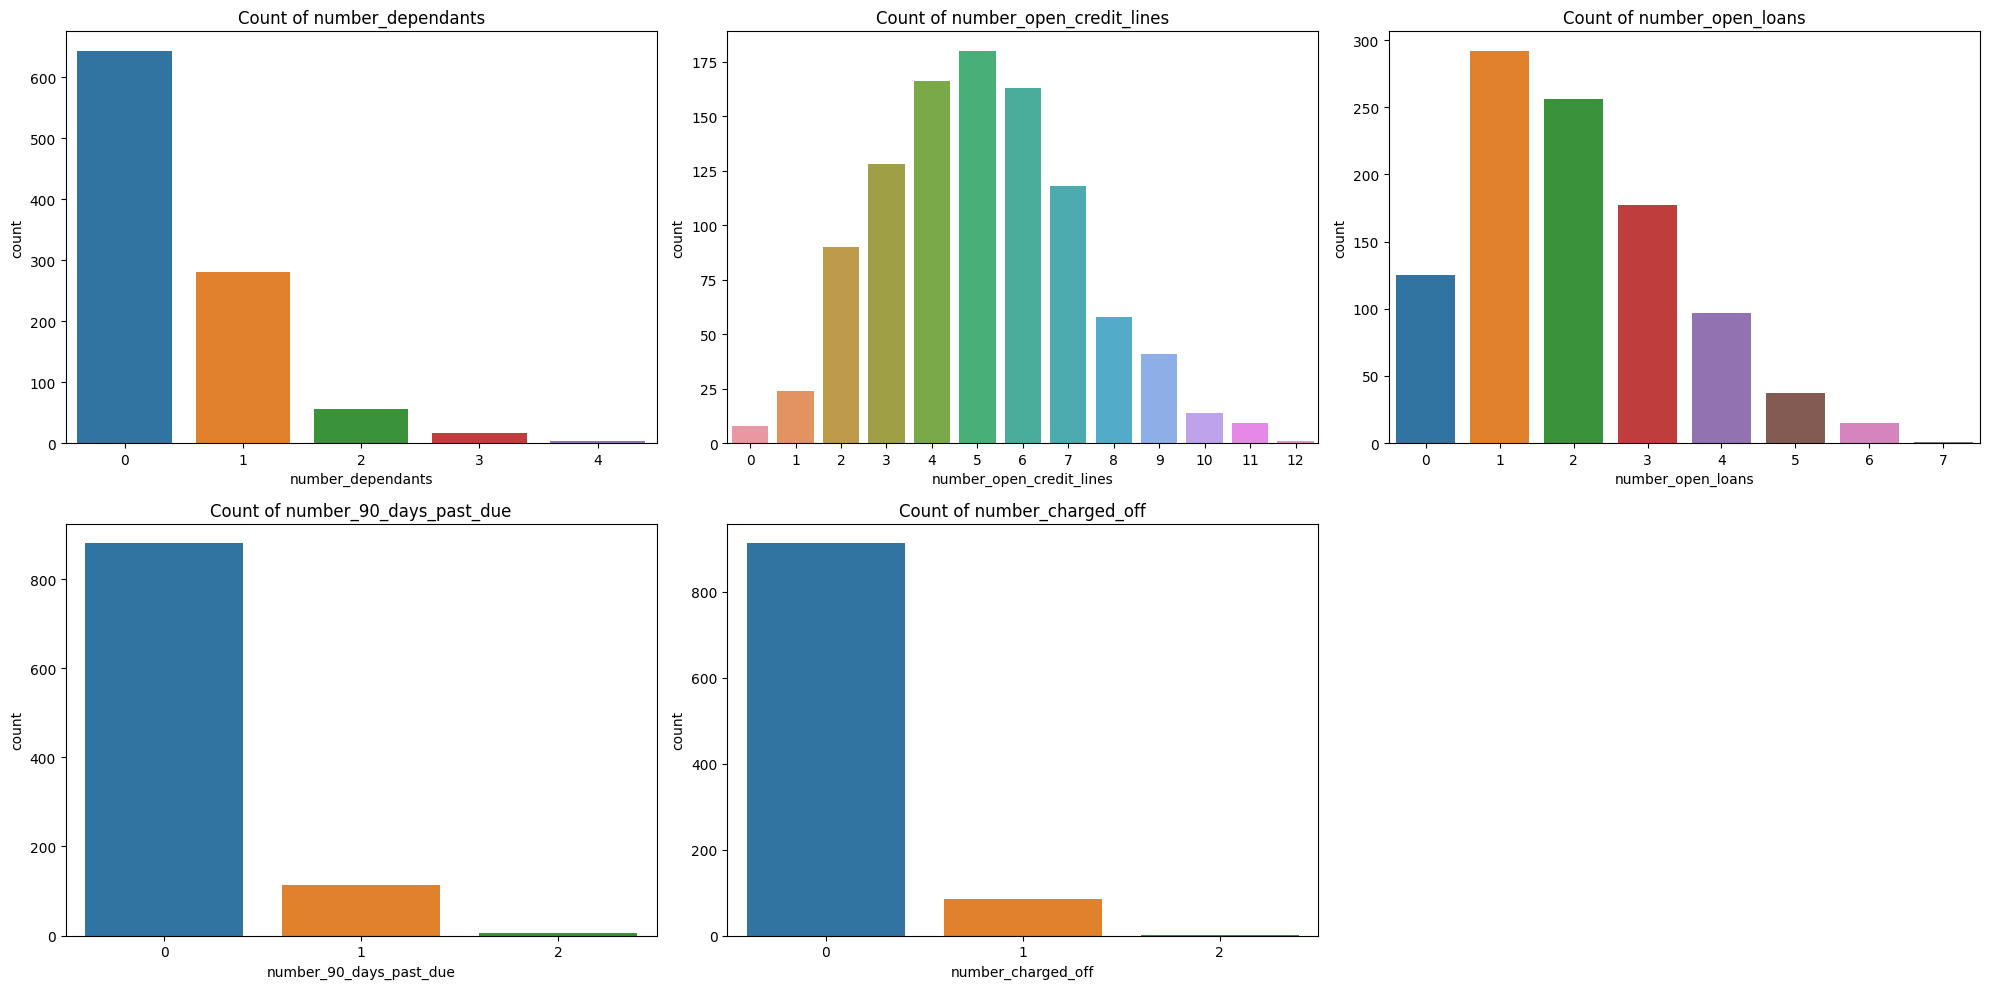

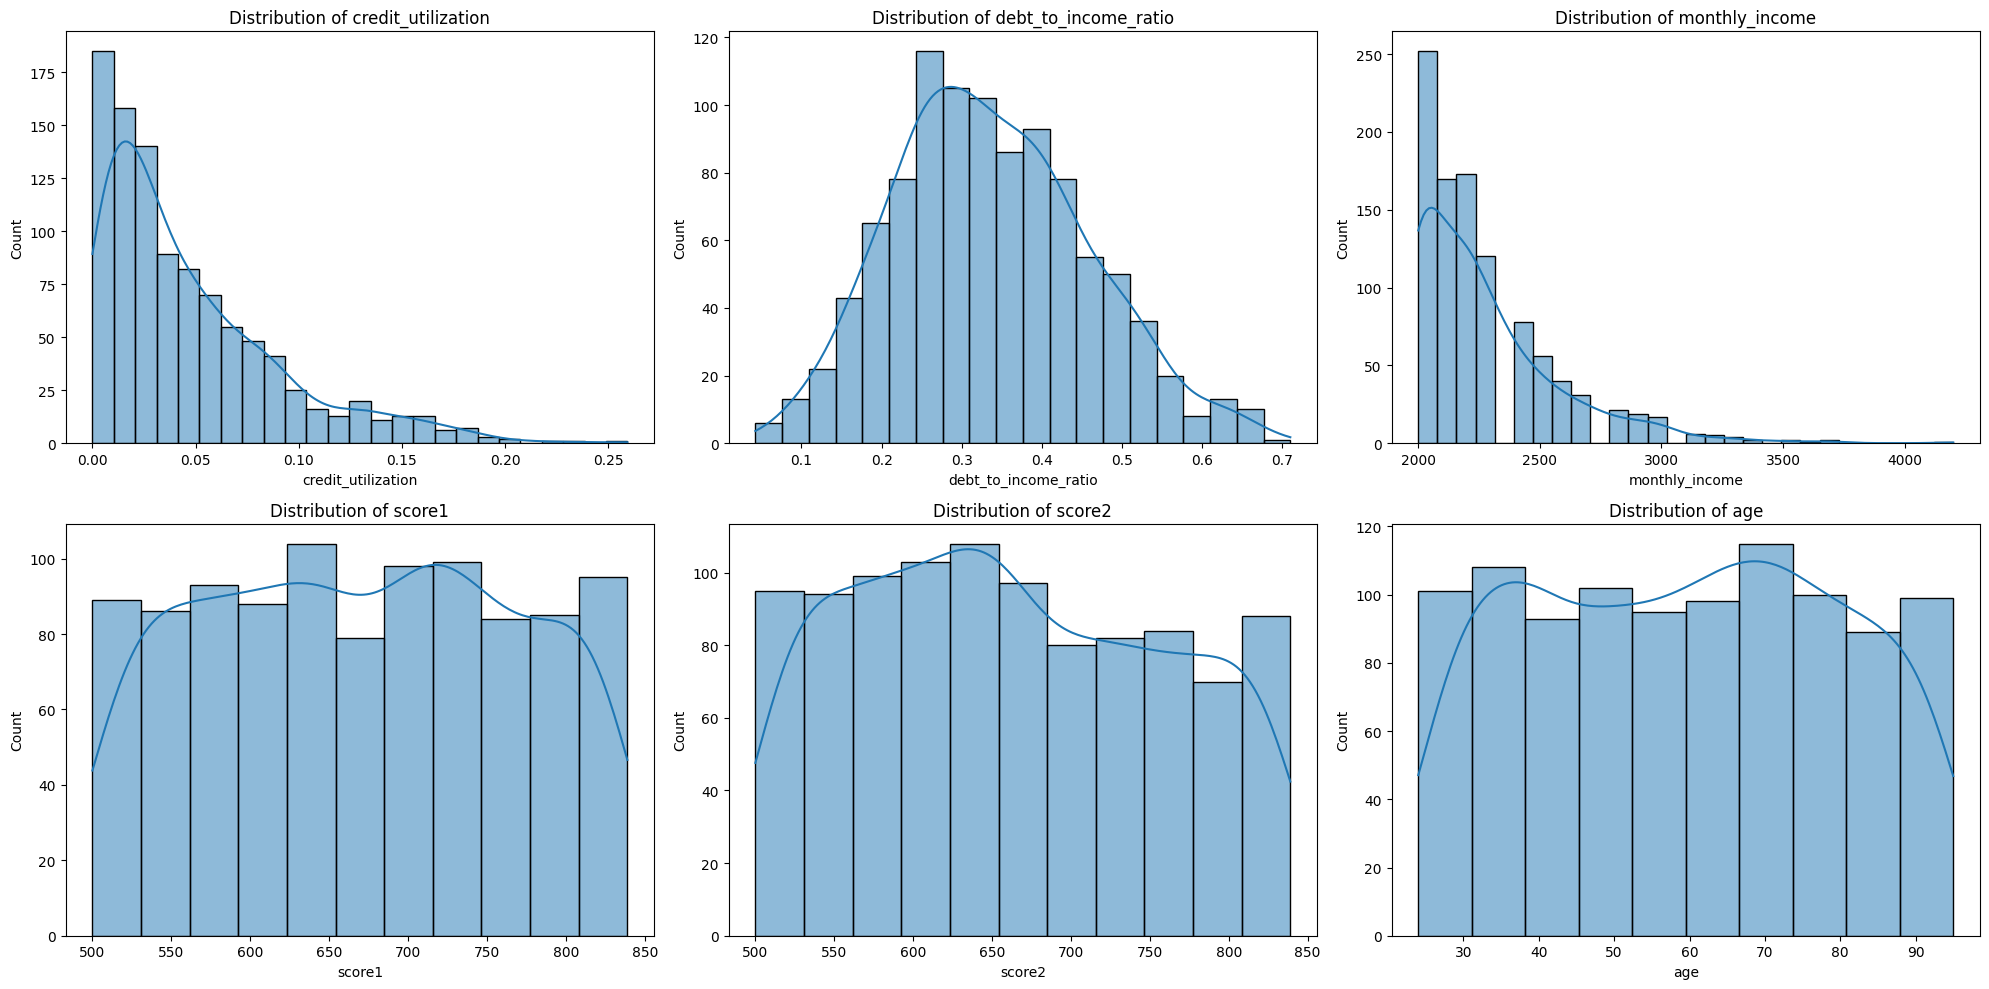

In [22]:
# Draw for test dataset
dis_countplot(test_df, discrete_columns)
con_histograms(test_df, continuous_columns)
plt.show()

Test dataset has similar distribution with train dataset, indicating there is no data drift.

## Boxplots against the target variable

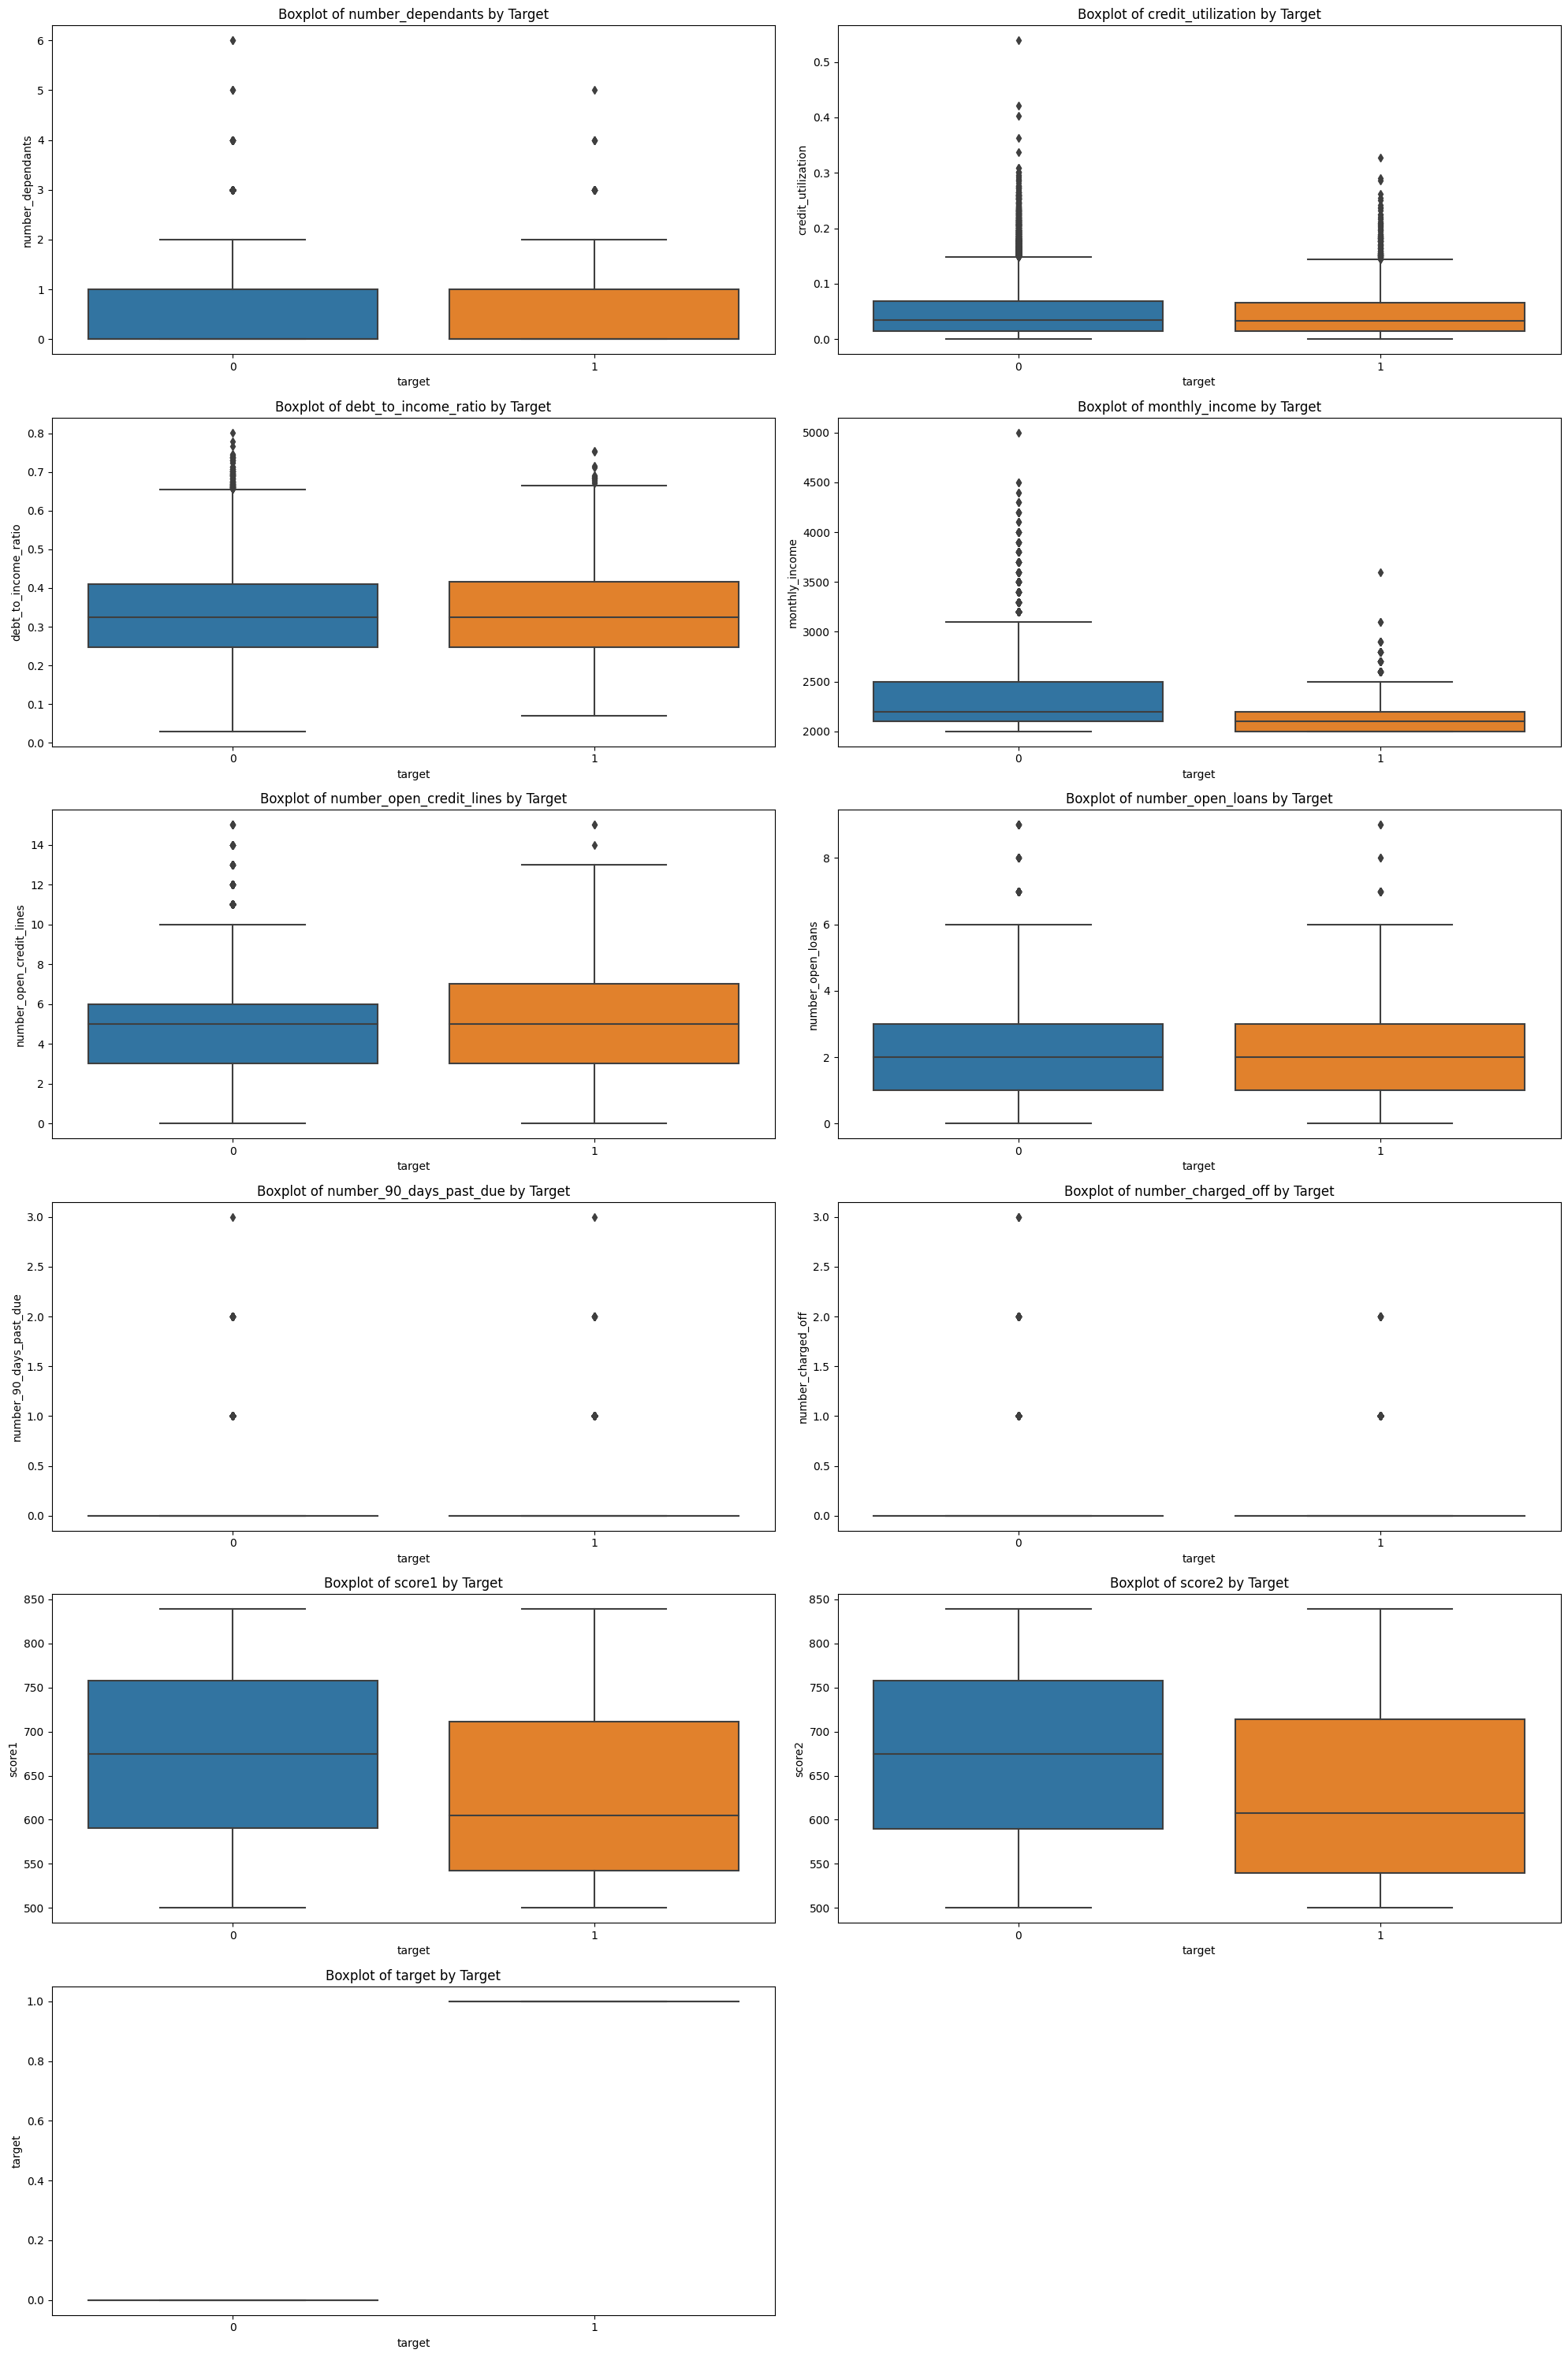

In [23]:
# Creating boxplots for each numerical variable against the target variable

# Setting up the matplotlib figure
plt.figure(figsize=(20, 30))

# Number of numerical columns (excluding 'target')
num_cols = len(train_df.columns) - 1

for i, col in enumerate(train_df.columns[:-1]): # Excluding 'target' from columns
    plt.subplot((num_cols + 1) // 2, 2, i + 1) # Creating subplots
    sns.boxplot(x='target', y=col, data=train_df)
    plt.title(f'Boxplot of {col} by Target')

plt.tight_layout()
plt.show()

*   number_dependants: similar distribution between two groups; >= 3 are outliers, 75% of customers has 0 or 1 dependant.
*   credit_utilization: similar distribution between two groups, but non-default group has more outliers than default group.
*   debt_to_income_ratio: 75% customer debt_to_income ratio is below 0.4 for both groups.
*   monthly_income: **non-default customers has high monthly income**.
*   number_open_credit_lines: **default group has high variance than non-default group**.
*   number_open_loans: similar distribution between two groups.
*   number_90_days_past_due	& number_charged_off: >=1 are outliers.
*   score1 & score2: **non-default has lower score1 and score2**.
*   age: similar distribution between two groups.

## Correlation and Multicollinearity

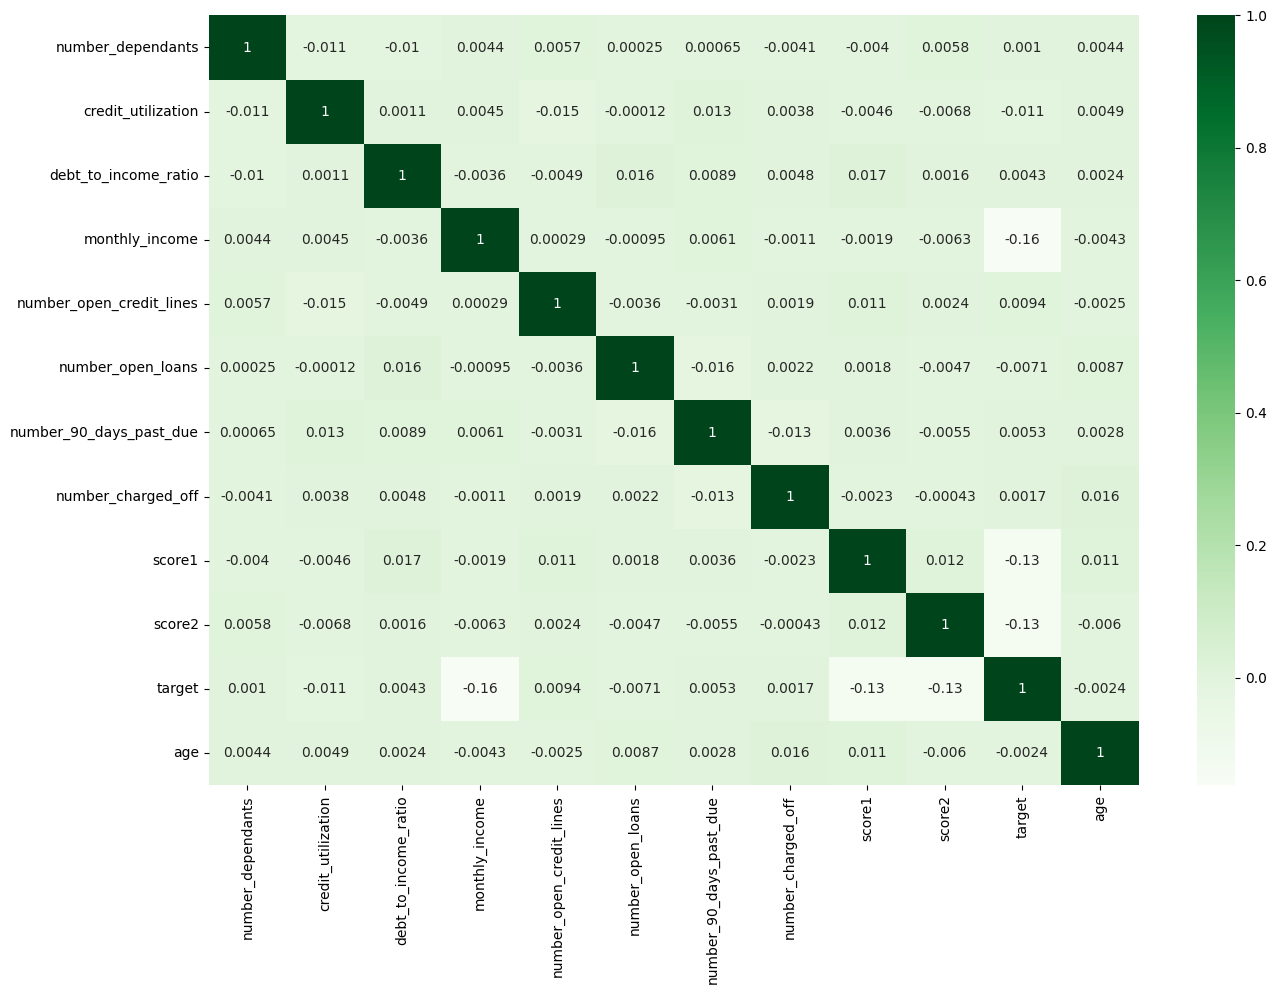

In [24]:
# plotting correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(train_df.corr(), cmap="Greens", annot=True)
plt.show()

* Multicollinearity: Most of the variables show very low correlation coefficients with each other (close to 0), which suggests there is little to no linear relationship between them. This is generally good for a regression model as it suggests low multicollinearity.
* Monthly_income, score1, and score2 has weakly negative relation with target.

# New feature ideas based on previous data exploration:

## Indicators:
*   90_days_past_due_ind: a binary indicator for whether the borrower has ever been 90 days past due. This feature can address outlier issue.
*   charged_off_ind: a binary indicator for whether the borrower has ever had a charge-off. This feature can address outlier issue.

## Binning group
*   monthly_income_group: group income into 3 quantiles as low(0), medium(1) and high income(2). This feature can address outlier issue.

## Interaction:
*  income_per_household: income/(number_dependants+1).
*  credit_utilization_total: credit_utilization * number_open_credit_lines.
*  loans_to_credit_lines_ratio: number_open_loans / number_open_credit_lines.


In [25]:
# create new indicator features
train_df['90_days_past_due_ind'] = train_df['number_90_days_past_due'].apply(lambda x: 0 if x == 0 else 1)
train_df['charged_off_ind'] = train_df['number_charged_off'].apply(lambda x: 0 if x == 0 else 1)
test_df['90_days_past_due_ind'] = test_df['number_90_days_past_due'].apply(lambda x: 0 if x == 0 else 1)
test_df['charged_off_ind'] = test_df['number_charged_off'].apply(lambda x: 0 if x == 0 else 1)

In [26]:
# create new binning group features
train_df['monthly_income_group'] = pd.qcut(train_df['monthly_income'], q=3, labels=[1,2,3])
train_df['monthly_income_group'] = pd.to_numeric(train_df['monthly_income_group'])
test_df['monthly_income_group'] = pd.qcut(test_df['monthly_income'], q=3, labels=[1,2,3])
test_df['monthly_income_group'] = pd.to_numeric(test_df['monthly_income_group'])

In [27]:
# create new interaction features
train_df['income_per_household'] = train_df['monthly_income'] / (train_df['number_dependants'] + 1) # add customer self
train_df['credit_utilization_total'] = train_df['credit_utilization'] * train_df['number_open_credit_lines']
test_df['income_per_household'] = test_df['monthly_income'] / (test_df['number_dependants'] + 1) # add customer self
test_df['credit_utilization_total'] = test_df['credit_utilization'] * test_df['number_open_credit_lines']

In [28]:
# reorder the columns
train_df = train_df[['number_dependants', 'credit_utilization', 'debt_to_income_ratio', \
               'monthly_income', 'monthly_income_group', \
               'number_open_credit_lines', 'number_open_loans', \
               'number_90_days_past_due', '90_days_past_due_ind', \
               'number_charged_off', 'charged_off_ind', \
               'score1', 'score2', 'age', \
               'income_per_household', 'credit_utilization_total', \
               'target']]
test_df = test_df[['number_dependants', 'credit_utilization', 'debt_to_income_ratio', \
               'monthly_income', 'monthly_income_group', \
               'number_open_credit_lines', 'number_open_loans', \
               'number_90_days_past_due', '90_days_past_due_ind', \
               'number_charged_off', 'charged_off_ind', \
               'score1', 'score2', 'age', \
               'income_per_household', 'credit_utilization_total']]

After creating new features, observe correlation matrix again

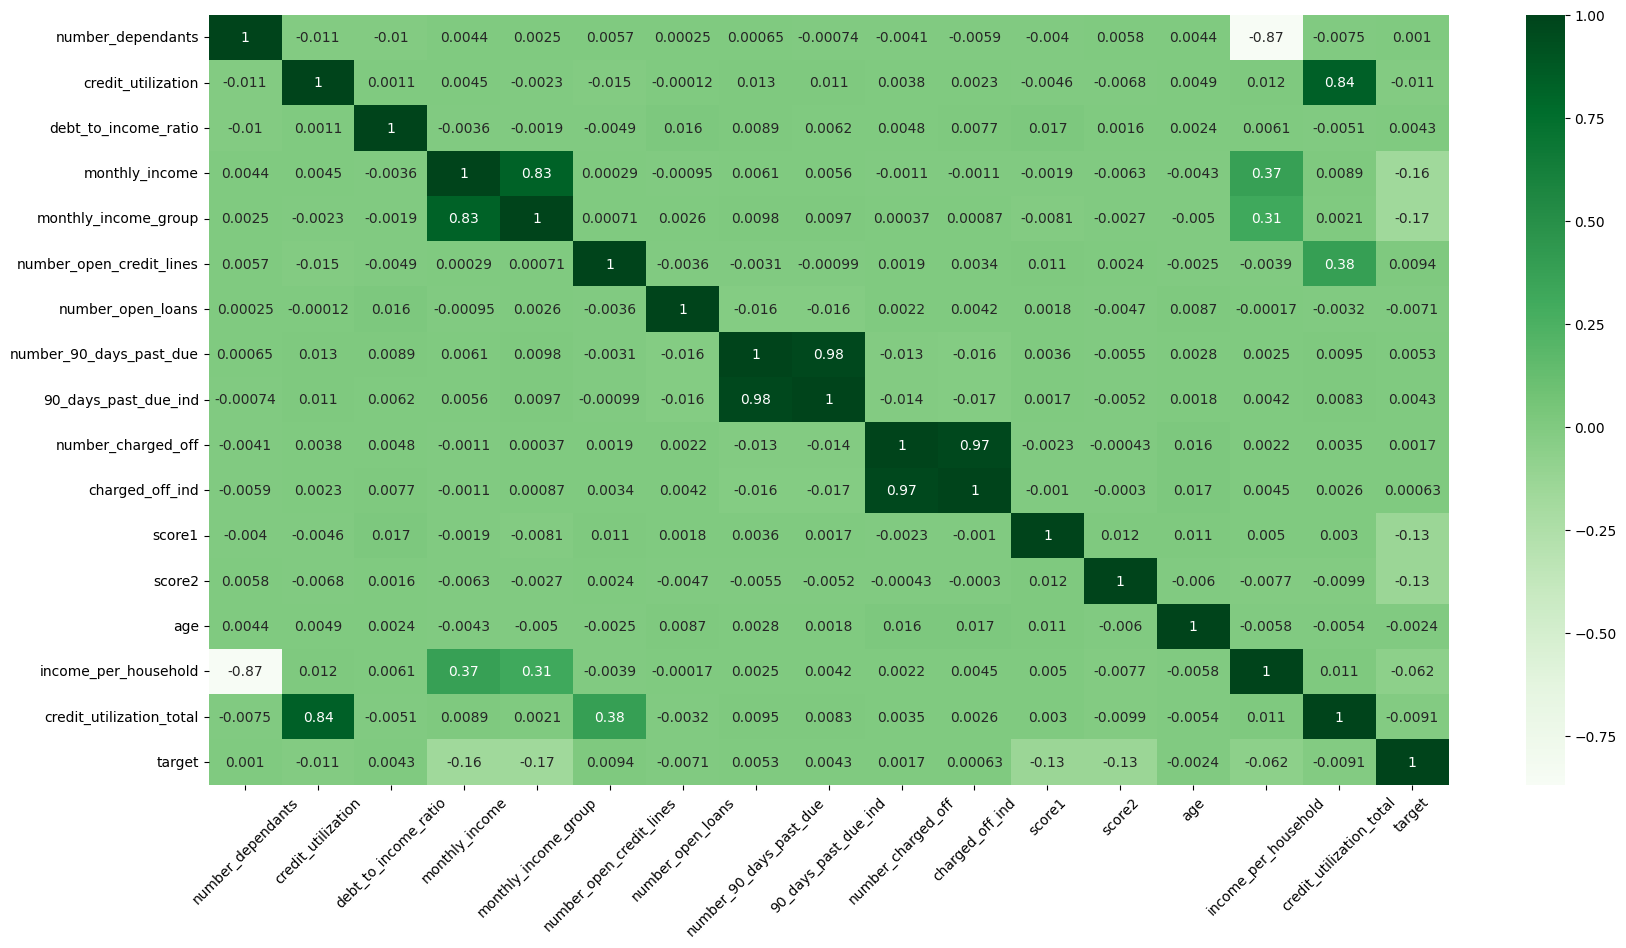

In [29]:
# plotting correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(train_df.corr(), cmap="Greens", annot=True)
plt.xticks(rotation=45)
plt.show()

* monthly_income_group has slightly high correlation than monthly_income with target.
* two indicator features have slightly lower correlation than original one.

# Feature Selection
From preivous correlation matrix, monthly_income, score1, and score2 has weak negative relationship with default variable.       
Next, use WOE & IV value to find predictive power of each variables.
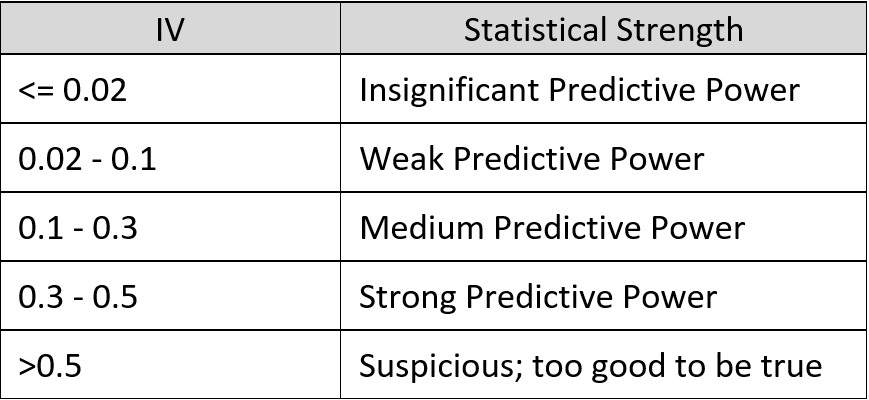

In [30]:
# Define a function to calculate Weight of Evidence (WOE) and Information Value (IV) for discrete variables
def calculate_woe_iv_discrete(data, target, feature):
    """
    Calculate the Weight of Evidence and Information Value for a given feature in the dataset.

    :param data: pandas DataFrame
    :param target: String, name of the target variable
    :param feature: String, name of the feature variable
    :return: DataFrame with WOE and IV values, and the IV value for the feature
    """
    # Create a table of frequency counts for each category of the feature
    table = pd.crosstab(data[feature], data[target])
    table['Total'] = table.sum(axis=1)
    table['Non-Event'] = table[0]
    table['Event'] = table[1]

    # Calculate the rate of event and non-event
    table['Event Rate'] = table['Event'] / table['Event'].sum()
    table['Non-Event Rate'] = table['Non-Event'] / table['Non-Event'].sum()

    # Calculate WOE
    table['WOE'] = np.log(table['Event Rate'] / table['Non-Event Rate'])

    # Calculate IV
    table['IV'] = (table['Event Rate'] - table['Non-Event Rate']) * table['WOE']

    # Replace any inf values with zeros
    table = table.replace({'WOE': {np.inf: 0, -np.inf: 0}})

    # Calculate the IV for the feature
    feature_iv = table['IV'].sum()

    return table[['Event Rate', 'Non-Event Rate', 'WOE', 'IV']], feature_iv

# Define a function to calculate WOE and IV for continuous variables
def calculate_woe_iv_continuous(data, target, feature, bins=10):
    """
    Calculate the Weight of Evidence and Information Value for a given continuous feature using binning.

    :param data: pandas DataFrame
    :param target: String, name of the target variable
    :param feature: String, name of the feature variable
    :param bins: Integer, number of bins to divide the data into
    :return: DataFrame with WOE and IV values for each bin, and the IV value for the feature
    """
    # Bin the continuous feature
    data['bin'] = pd.qcut(data[feature], q=bins, duplicates='drop')

    # Create a table of frequency counts for each bin
    table = pd.crosstab(data['bin'], data[target])
    table['Total'] = table.sum(axis=1)
    table['Non-Event'] = table[0]
    table['Event'] = table[1]

    # Calculate the rate of event and non-event
    table['Event Rate'] = table['Event'] / table['Event'].sum()
    table['Non-Event Rate'] = table['Non-Event'] / table['Non-Event'].sum()

    # Calculate WOE
    table['WOE'] = np.log(table['Event Rate'] / table['Non-Event Rate'])

    # Calculate IV
    table['IV'] = (table['Event Rate'] - table['Non-Event Rate']) * table['WOE']

    # Replace any inf values with zeros
    table = table.replace({'WOE': {np.inf: 0, -np.inf: 0}})

    # Calculate the IV for the feature
    feature_iv = table['IV'].sum()

    # Drop the bin column
    data.drop('bin', axis=1, inplace=True)

    return table[['Event Rate', 'Non-Event Rate', 'WOE', 'IV']], feature_iv


In [31]:
# Calculate WOE and IV for each discrete column
discrete_columns = ['number_dependants', 'number_open_credit_lines', 'number_open_loans', \
                    'number_90_days_past_due', '90_days_past_due_ind', 'number_charged_off', 'charged_off_ind', \
                    'monthly_income_group']

iv_values_discrete = {}
for col in discrete_columns:
    _, iv = calculate_woe_iv_discrete(train_df, 'target', col)
    iv_values_discrete[col] = iv

iv_values_discrete

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'number_dependants': inf,
 'number_open_credit_lines': 0.007209659560587096,
 'number_open_loans': 0.004101425195691783,
 'number_90_days_past_due': 0.001086851014990088,
 '90_days_past_due_ind': 0.00020069246936534174,
 'number_charged_off': inf,
 'charged_off_ind': 4.3707822442896684e-06,
 'monthly_income_group': 0.3791417329185245}

Based on IV value, only monthly_income group has strong predictive power.

In [32]:
# Calculate WOE and IV for each continuous columns
continuous_columns = ['credit_utilization', 'debt_to_income_ratio', 'monthly_income', 'score1', 'score2', 'age', 'income_per_household', 'credit_utilization_total']

# Calculate WOE and IV for each continuous column
iv_values_continuous = {}
for col in continuous_columns:
    _, iv = calculate_woe_iv_continuous(train_df, 'target', col)
    iv_values_continuous[col] = iv

iv_values_continuous

{'credit_utilization': 0.006916309466413171,
 'debt_to_income_ratio': 0.004250208731734732,
 'monthly_income': 0.4841937170521453,
 'score1': 0.2219247289319959,
 'score2': 0.22575966937661035,
 'age': 0.00454116018782855,
 'income_per_household': 0.2621279499228333,
 'credit_utilization_total': 0.003961938636829361}

Based on IV value, monthly_income, score1, score2 and income_per_household have medium predictive power.

# Random Forest Classifier to select features

In [33]:
# Separate features and target variable
X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

# Initialize the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to get feature importances
rf.fit(X_train, y_train)

# Select features using feature importances
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)

# Get the selected feature names
selected_features = X_train.columns[(selector.get_support())]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [34]:
selected_features

Index(['credit_utilization', 'debt_to_income_ratio', 'score1', 'score2', 'age',
       'credit_utilization_total'],
      dtype='object')

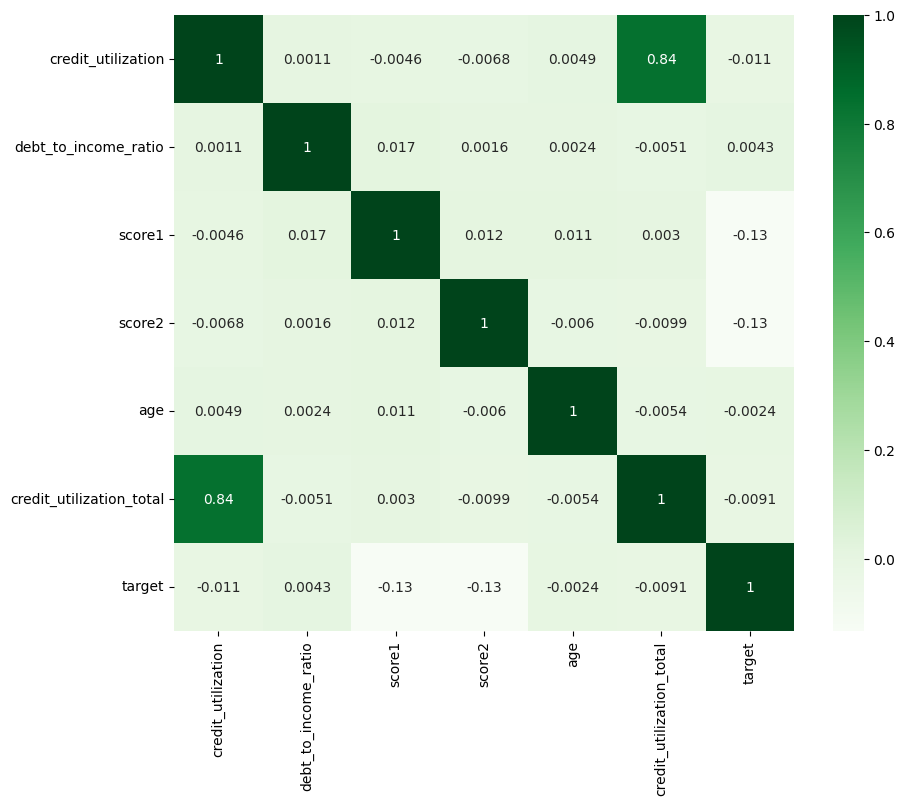

In [35]:
# selected feature correlation
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[list(selected_features)+['target']].corr(), cmap="Greens", annot=True)
plt.show()

Credit_utilization and credit_utilization_total has high correlation. Based on IV value and correlation value with target, select credit_utilization.

In [36]:
selected_features = selected_features.tolist()
selected_features.remove('credit_utilization_total')
selected_features.append('monthly_income_group')

In [37]:
selected_features

['credit_utilization',
 'debt_to_income_ratio',
 'score1',
 'score2',
 'age',
 'monthly_income_group']

# Transformation
* Boxcox: credit_utilization
* Min_max: score1, score2, age, monthly_income_group since it is not normally distributed.

In [38]:
# Box-Cox Transformation
train_df['credit_utilization'], fitted_lambda = stats.boxcox(train_df['credit_utilization'])
test_df['credit_utilization'] = stats.boxcox(test_df['credit_utilization'], fitted_lambda)

# Min-Max Scaling
min_max_cols = ['score1', 'score2', 'age', 'monthly_income_group']

min_max_scaler = MinMaxScaler()
train_df[min_max_cols] = min_max_scaler.fit_transform(train_df[min_max_cols])
test_df[min_max_cols] = min_max_scaler.transform(test_df[min_max_cols])

# Model fitting

In [39]:
# Splitting data into training and testing sets
X = train_df[selected_features]
y = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling

In [40]:
# Applying SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

## Hyperparameter Tuning

In [41]:
# Initialize models
model_params = {
    'random_forest_bal': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params' : {
                'n_estimators': [5, 10, 20],
                'max_depth': [2, 3, 5, 10, None],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'bootstrap': [True, False]
        }
    },
    'logistic_regression_bal' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto', class_weight='balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'decision_tree_bal': {
        'model': DecisionTreeClassifier(class_weight='balanced'),
        'params': {
            'max_depth': [3, 4, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'knn':{
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 11, 19],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'gbm_bal': {
        'model': XGBClassifier(scale_pos_weight=(y_train.count() - y_train.sum()) /y_train.sum()),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [1e-5, 1e-3, 0.01],
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    },
    'adaboost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0],
            'algorithm': ['SAMME', 'SAMME.R'],
            'estimator': [None, DecisionTreeClassifier(class_weight='balanced')]
        }
    }
}

In [42]:
# Training and evaluating models using cross-validation and GridSearch
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=make_scorer(average_precision_score), return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score_aucPR': clf.best_score_,
        'best_params': clf.best_params_
    })

In [43]:
# # Running for new models
# for model_name, mp in new_model_params.items():
#     clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=make_scorer(average_precision_score), return_train_score=False, n_jobs=-1)
#     clf.fit(X_train, y_train)
#     scores.append({
#         'model': model_name,
#         'best_score_aucPR': clf.best_score_,
#         'best_params': clf.best_params_
#     })

In [44]:
df = pd.DataFrame(scores,columns=['model','best_score_aucPR','best_params'])
pd.set_option('max_colwidth', 400)
df

,model,best_score_aucPR,best_params
0,random_forest_bal,0.173613,"{'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}"
1,logistic_regression_bal,0.161880,{'C': 5}
2,decision_tree_bal,0.166150,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}"
3,knn,0.110750,"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}"
4,gbm_bal,0.177095,"{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}"
5,adaboost,0.112927,"{'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(class_weight='balanced'), 'learning_rate': 1.0, 'n_estimators': 100}"


In [45]:
# Initialize models for SMOTE balance data
model_params_smote = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
                'n_estimators': [5, 10, 20],
                'max_depth': [2, 3, 5, 10, None],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'bootstrap': [True, False]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 4, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'knn':{
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 11, 19],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'gbm_bal': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [1e-5, 1e-3, 0.01, 0.1],
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    },
    'adaboost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
}

In [46]:
# Training and evaluating models using cross-validation and GridSearch
scores_smote = []

for model_name, mp in model_params_smote.items():
    clf_smote = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=make_scorer(roc_auc_score), return_train_score=False, n_jobs=-1)
    clf_smote.fit(X_smote, y_smote)
    scores_smote.append({
        'model': model_name,
        'best_score_aucROC': clf_smote.best_score_,
        'best_params': clf_smote.best_params_
    })

In [47]:
# # Running for new models
# for model_name, mp in new_model_params_smote.items():
#     clf_smote = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=make_scorer(roc_auc_score), return_train_score=False, n_jobs=-1)
#     clf_smote.fit(X_smote, y_smote)
#     scores_smote.append({
#         'model': model_name,
#         'best_score_aucROC': clf_smote.best_score_,
#         'best_params': clf_smote.best_params_
#     })

In [48]:
df_smote = pd.DataFrame(scores_smote,columns=['model','best_score_aucROC','best_params'])
pd.set_option('max_colwidth', 400)
df_smote['model'] = df_smote['model'].apply(lambda x: x+'_smote')
df_smote

,model,best_score_aucROC,best_params
0,random_forest_smote,0.884808,"{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}"
1,logistic_regression_smote,0.681846,{'C': 1}
2,decision_tree_smote,0.816887,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}"
3,knn_smote,0.871498,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}"
4,gbm_bal_smote,0.872834,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}"
5,adaboost_smote,0.723046,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}"


## model summary

In [49]:
df.sort_values(by='best_score_aucPR', ascending=False)[:4]

,model,best_score_aucPR,best_params
4,gbm_bal,0.177095,"{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}"
0,random_forest_bal,0.173613,"{'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}"
2,decision_tree_bal,0.166150,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}"
1,logistic_regression_bal,0.161880,{'C': 5}


In [50]:
df_smote.sort_values(by='best_score_aucROC', ascending=False)[:3]

,model,best_score_aucROC,best_params
0,random_forest_smote,0.884808,"{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}"
4,gbm_bal_smote,0.872834,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}"
3,knn_smote,0.871498,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}"


In [51]:
model_sum = pd.concat([df.sort_values(by='best_score_aucPR', ascending=False)[:4], df_smote.sort_values(by='best_score_aucROC', ascending=False)[:3]])
model_sum[['model', 'best_score_aucPR', 'best_score_aucROC', 'best_params']]

,model,best_score_aucPR,best_score_aucROC,best_params
4,gbm_bal,0.177095,NaN,"{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}"
0,random_forest_bal,0.173613,NaN,"{'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}"
2,decision_tree_bal,0.166150,NaN,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}"
1,logistic_regression_bal,0.161880,NaN,{'C': 5}
0,random_forest_smote,NaN,0.884808,"{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}"
4,gbm_bal_smote,NaN,0.872834,"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}"
3,knn_smote,NaN,0.871498,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}"


Select those 7 models.

# Evaluation

In [52]:
def eval_model(model, dtrain_X, dtrain_Y, dtest_X, dtest_Y):
    '''
    This function takes an classification model, fits that model to training data,
    predicts on test data and creates evaluation metrics
    INPUT:
    model: the model to be evaluated
    dtrain_X: training data
    dtrain_Y: training labels
    dtest_X: test data
    dtest_Y: test labels
    cols: columns of the data
    '''
    # Fit the model on the training data
    model.fit(dtrain_X,dtrain_Y)

    # Predictions on training and test sets
    train_predictions = model.predict(dtrain_X)
    train_predictions_prob = model.predict_proba(dtrain_X)[:,1]
    test_predictions = model.predict(dtest_X)
    test_predictions_prob = model.predict_proba(dtest_X)[:,1]

    # Calculate F1 score for each threshold
    precisions, recalls, thresholds = precision_recall_curve(dtrain_Y, train_predictions_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores) # Replace NaN values with zero
    # Find the index of the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    # The optimal threshold is the threshold at the max F1 index
    optimal_threshold = thresholds[max_f1_index]
    optimal_f1_score = f1_scores[max_f1_index]

    # Convert probabilities to binary predictions based on the optimal threshold
    train_predictions_optimal = (train_predictions_prob >= optimal_threshold).astype(int)
    test_predictions_optimal = (test_predictions_prob >= optimal_threshold).astype(int)

    # Constructing the model name with all hyperparameters
    # Get current hyperparameters
    current_params = model.get_params()

    # Create a default model instance
    default_params = model.__class__().get_params()

    # Identify non-default hyperparameters
    non_default_params = {k: v for k, v in current_params.items() if v != default_params[k]}

    # Constructing the model name with non-default hyperparameters
    non_default_params_str = ", ".join(f"{key}={value}" for key, value in non_default_params.items())
    model_name = f"{type(model).__name__}({non_default_params_str})" if non_default_params_str else type(model).__name__

    # Calculate and summarize metrics
    metrics = {
        'Model': model_name,
        'Training ROC-AUC-Score': roc_auc_score(dtrain_Y, train_predictions_prob),
        'Validation ROC-AUC-Score': roc_auc_score(dtest_Y, test_predictions_prob),
        'Training PR-AUC-Score': average_precision_score(dtrain_Y, train_predictions_prob),
        'Validation PR-AUC-Score': average_precision_score(dtest_Y, test_predictions_prob),
        'Training Accuracy': accuracy_score(dtrain_Y, train_predictions_optimal),
        'Validation Accuracy': accuracy_score(dtest_Y, test_predictions_optimal),
        'Training Precision': precisions[max_f1_index],
        'Validation Precision': precision_score(dtest_Y, test_predictions_optimal),
        'Training Recall': recalls[max_f1_index],
        'Validation Recall': recall_score(dtest_Y, test_predictions_optimal),
        'Training F1-Score': optimal_f1_score,
        'Validation F1-Score': f1_score(dtest_Y, test_predictions_optimal),

    }

    # Compute confusion matrices for training and testing
    cm_train = confusion_matrix(dtrain_Y, train_predictions_optimal, labels=model.classes_)
    cm_test = confusion_matrix(dtest_Y, test_predictions_optimal, labels=model.classes_)

    # Create confusion matrix displays
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                        display_labels=model.classes_)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=model.classes_)

    # Plot for training set
    disp_train.plot()
    plt.title('Confusion Matrix for Training Set')

    # Plot for testing set
    disp_test.plot()
    plt.title('Confusion Matrix for Testing Set')

    return pd.DataFrame(metrics, index=[0])
    # return metrics
    # predictions = model.predict(dtest_X)
    # print(model)

    # print("Accuracy score: ", accuracy_score(predictions,dtest_Y))
    # print("Recall score: ", recall_score(predictions,dtest_Y))
    # print("F1 score: ", f1_score(predictions,dtest_Y))

    # fig = plt.figure(figsize=(10,8))
    # ax = fig.add_subplot(111)
    # prediction_probabilities = model.predict_proba(dtest_X)[:,1]
    # fpr , tpr , thresholds = roc_curve(dtest_Y,prediction_probabilities)
    # ax.plot(fpr,tpr,label = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    # ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    # plt.legend(loc="best")
    # plt.title("ROC-CURVE and AREA UNDER CURVE")
    # ax.set_facecolor("k")

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"XGBClassifier(colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=5, missing=nan, n_estimators=100, scale_pos_weight=8.905525846702318, subsample=0.5)",0.840666,0.775338,0.382943,0.295064,0.829044,0.81262,0.316567,0.291925,0.598336,0.526906,0.414062,0.375699


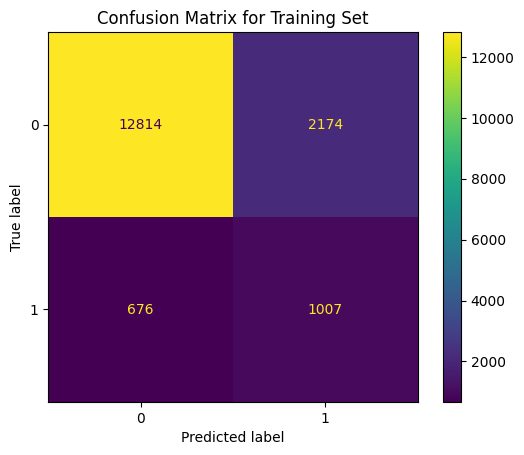

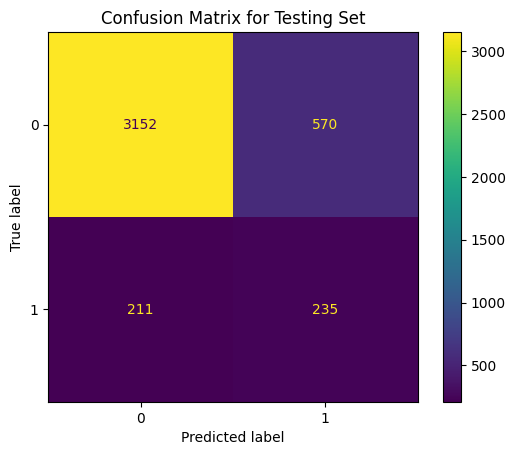

In [53]:
gbm_bal = XGBClassifier(scale_pos_weight=(y_train.count() - y_train.sum()) /y_train.sum(), **model_sum[model_sum['model'] == 'gbm_bal']['best_params'].iloc[0])
gbm_bal_result = eval_model(gbm_bal, X_train, y_train, X_valid, y_valid)
gbm_bal_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"RandomForestClassifier(class_weight=balanced, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=20)",0.755021,0.759048,0.236419,0.248542,0.73241,0.742562,0.219053,0.243663,0.643494,0.668161,0.326845,0.3571


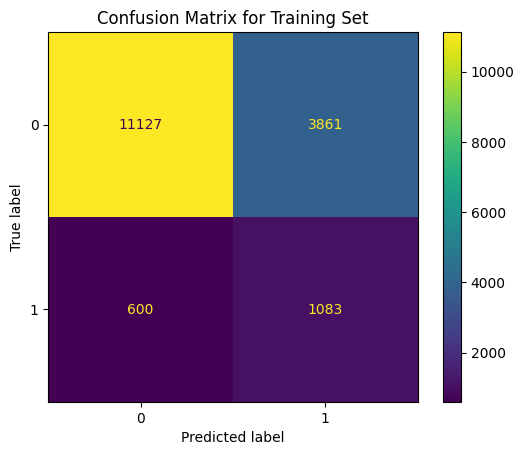

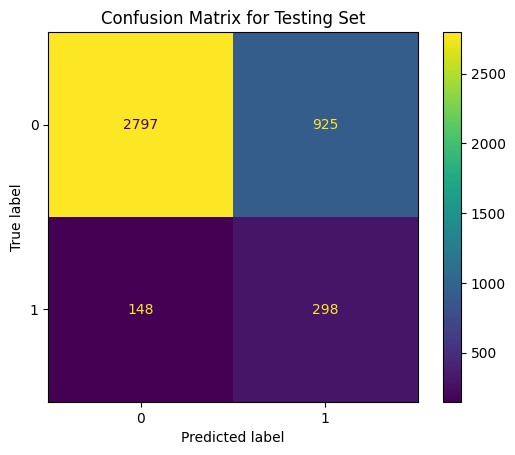

In [54]:
# Random Forest
random_forest_bal = RandomForestClassifier(class_weight='balanced', **df[df['model'] == 'random_forest_bal']['best_params'].iloc[0])
random_forest_bal_result = eval_model(random_forest_bal, X_train, y_train, X_valid, y_valid)
random_forest_bal_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"DecisionTreeClassifier(class_weight=balanced, criterion=entropy, max_depth=3)",0.738347,0.743559,0.200055,0.216411,0.639374,0.643714,0.188337,0.204662,0.777184,0.807175,0.303199,0.326531


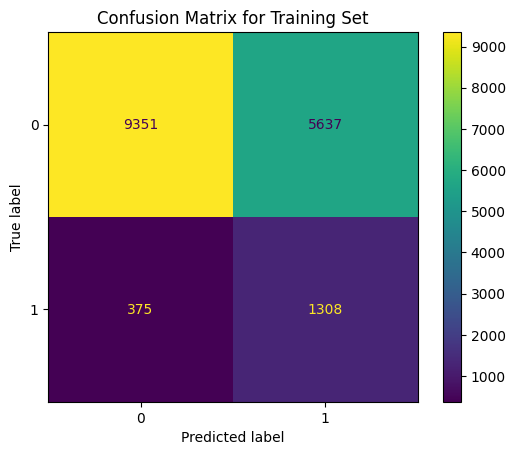

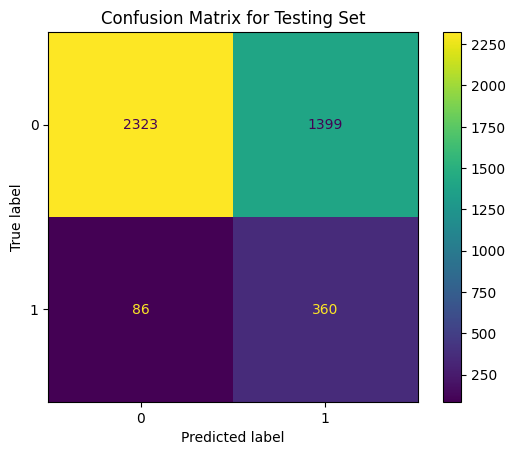

In [55]:
decision_tree_bal = DecisionTreeClassifier(class_weight='balanced', **df[df['model'] == 'decision_tree_bal']['best_params'].iloc[0])
decision_tree_bal_result = eval_model(decision_tree_bal, X_train, y_train, X_valid, y_valid)
decision_tree_bal_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"LogisticRegression(C=5, class_weight=balanced)",0.737974,0.747916,0.224214,0.251474,0.778897,0.779511,0.225391,0.245972,0.488414,0.513453,0.308443,0.332607


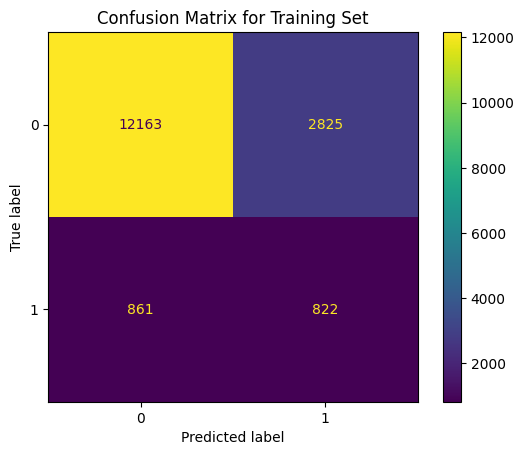

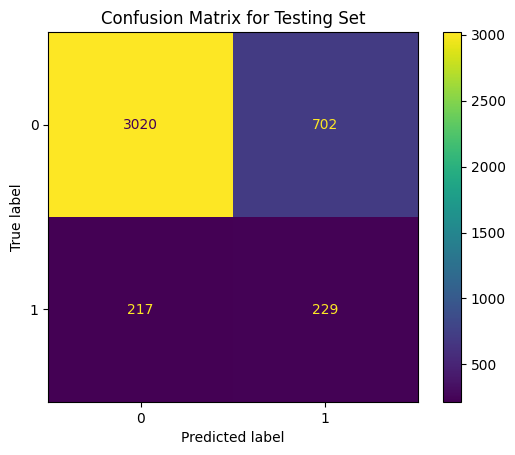

In [56]:
# logistic regression
logistic_regression_bal = LogisticRegression(class_weight='balanced', **df[df['model'] == 'logistic_regression_bal']['best_params'].iloc[0])
logistic_regression_bal_result = eval_model(logistic_regression_bal, X_train, y_train, X_valid, y_valid)
logistic_regression_bal_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=1, missing=nan, n_estimators=200, subsample=0.7)",0.997014,0.719335,0.997155,0.222377,0.973479,0.819818,0.969376,0.256778,0.977849,0.360987,0.973594,0.300093


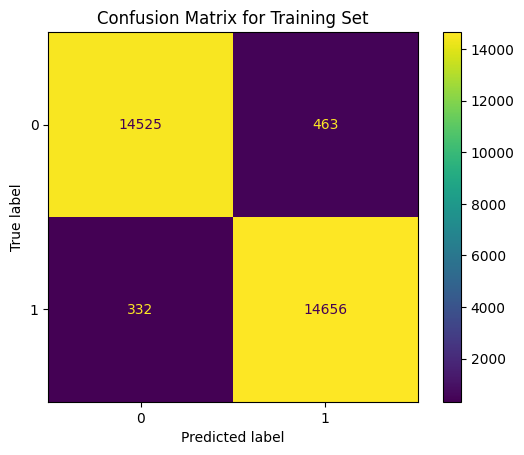

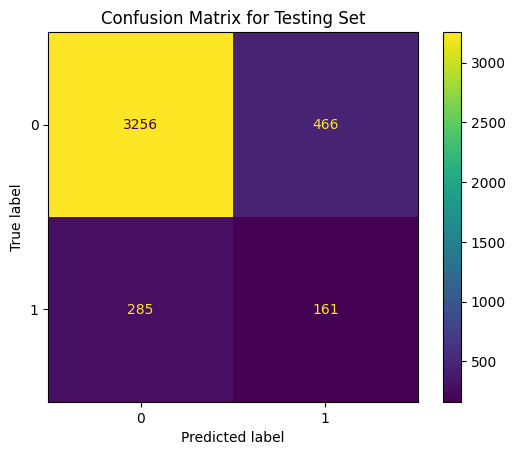

In [57]:
# gbm_bal_smote
gbm_bal_smote = XGBClassifier(**model_sum[model_sum['model'] == 'gbm_bal_smote']['best_params'].iloc[0])
gbm_bal_smote_result = eval_model(gbm_bal_smote, X_smote, y_smote, X_valid, y_valid)
gbm_bal_smote_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=20)",1.0,0.716622,1.0,0.214712,1.0,0.854607,1.0,0.245223,1.0,0.172646,1.0,0.202632


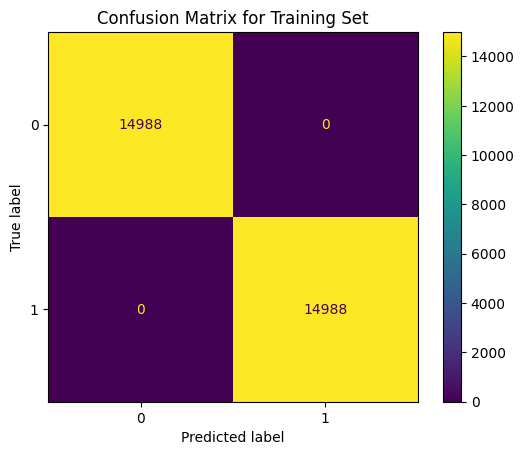

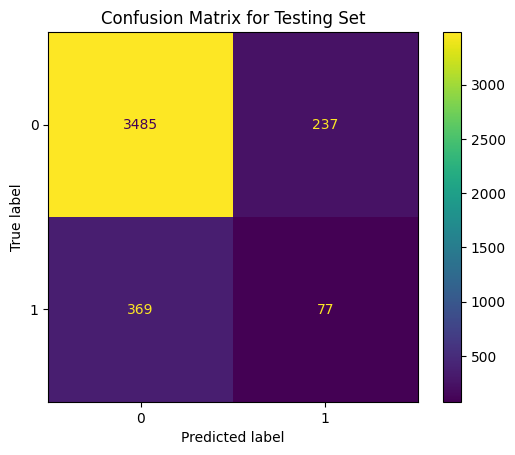

In [58]:
# random_forest_smote
random_forest_smote = RandomForestClassifier(**model_sum[model_sum['model'] == 'random_forest_smote']['best_params'].iloc[0])
random_forest_smote_result = eval_model(random_forest_smote, X_smote, y_smote, X_valid, y_valid)
random_forest_smote_result

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"KNeighborsClassifier(metric=euclidean, n_neighbors=3, weights=distance)",1.0,0.61772,1.0,0.14914,1.0,0.822217,1.0,0.193347,1.0,0.20852,1.0,0.200647


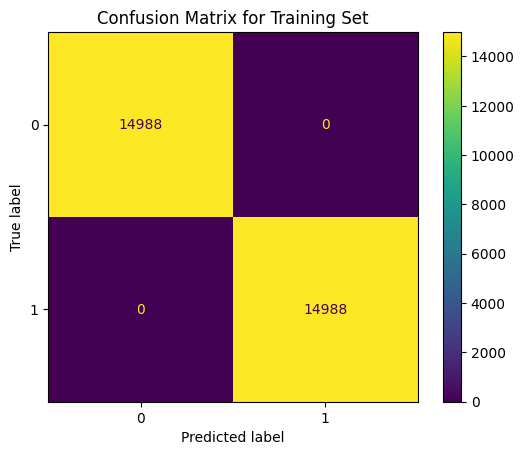

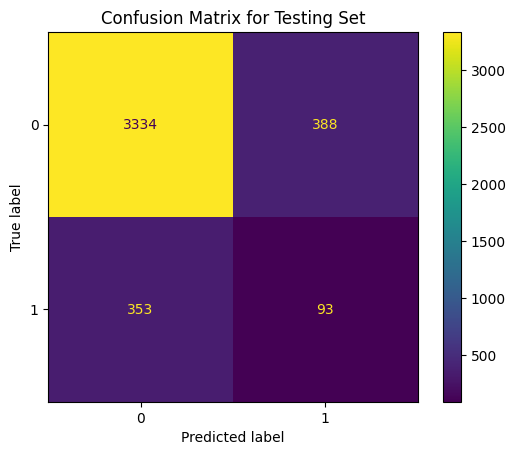

In [59]:
# knn_smote
knn_smote = KNeighborsClassifier(**model_sum[model_sum['model'] == 'knn_smote']['best_params'].iloc[0])
knn_smote_result = eval_model(knn_smote, X_smote, y_smote, X_valid, y_valid)
knn_smote_result

## Evaluation Result

In [60]:
metric_df = pd.concat([gbm_bal_result, random_forest_bal_result, decision_tree_bal_result, logistic_regression_bal_result], ignore_index=True)
# , gbm_bal_smote_result, random_forest_smote_result, knn_smote_result
metric_df

,Model,Training ROC-AUC-Score,Validation ROC-AUC-Score,Training PR-AUC-Score,Validation PR-AUC-Score,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1-Score,Validation F1-Score
0,"XGBClassifier(colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=5, missing=nan, n_estimators=100, scale_pos_weight=8.905525846702318, subsample=0.5)",0.840666,0.775338,0.382943,0.295064,0.829044,0.812620,0.316567,0.291925,0.598336,0.526906,0.414062,0.375699
1,"RandomForestClassifier(class_weight=balanced, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=20)",0.755021,0.759048,0.236419,0.248542,0.732410,0.742562,0.219053,0.243663,0.643494,0.668161,0.326845,0.357100
2,"DecisionTreeClassifier(class_weight=balanced, criterion=entropy, max_depth=3)",0.738347,0.743559,0.200055,0.216411,0.639374,0.643714,0.188337,0.204662,0.777184,0.807175,0.303199,0.326531
3,"LogisticRegression(C=5, class_weight=balanced)",0.737974,0.747916,0.224214,0.251474,0.778897,0.779511,0.225391,0.245972,0.488414,0.513453,0.308443,0.332607


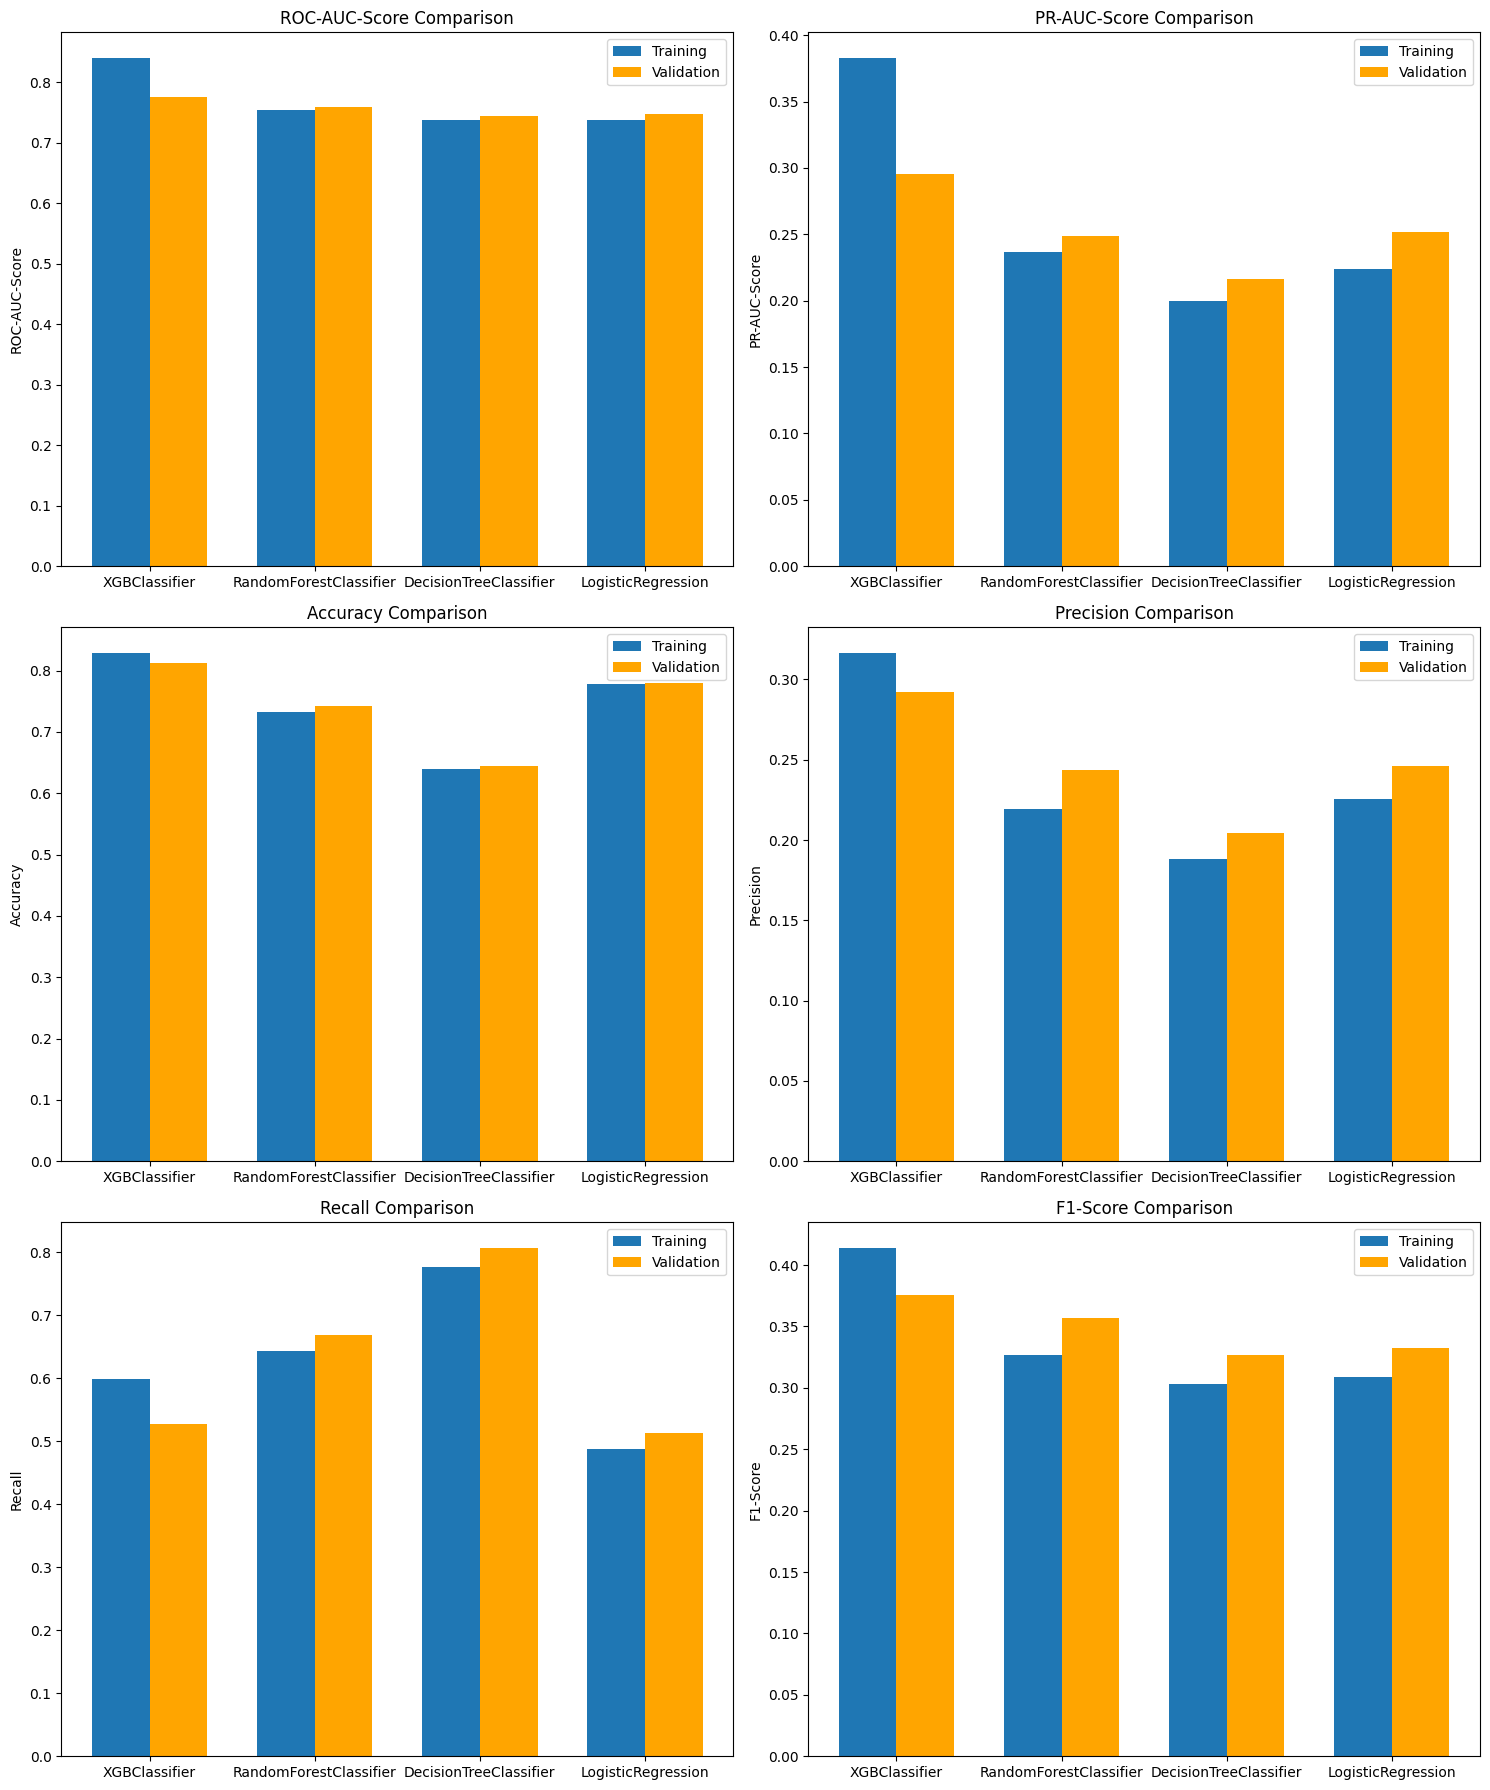

In [61]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

# Flatten axes for easy iterating
axes = axes.flatten()

# Define metrics to plot
metrics = ['ROC-AUC-Score', 'PR-AUC-Score', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Plot each metric
for i, metric in enumerate(metrics):
    training_metric = metric_df['Training ' + metric]
    validation_metric = metric_df['Validation ' + metric]

    x = np.arange(len(metric_df))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting both training and validation metrics in the same graph
    axes[i].bar(x - width/2, training_metric, width, label='Training')
    axes[i].bar(x + width/2, validation_metric, width, label='Validation', color='orange')

    axes[i].set_ylabel(metric)
    axes[i].set_title(metric + ' Comparison')
    axes[i].set_xticks(x)  # Adjusting the x-ticks to align labels slightly to the left
    axes[i].set_xticklabels(metric_df['Model'].apply(lambda x:x.split('(')[0]))
    axes[i].legend()

plt.tight_layout()
plt.show()

**No Overfit for model trained with original data, but all models trained with SMOTE is overfit.**       
XGBClassifier and RandomForestClassifier have similar performance and are the best among other models.

# Prediction

## Random Forest

In [62]:
# select optimal threshold for random forest

# model
rfc = RandomForestClassifier(class_weight='balanced', **df[df['model'] == 'random_forest_bal']['best_params'].iloc[0])
rfc.fit(X, y)
prediction_probabilities_rfc = rfc.predict_proba(X)[:,1]

# Predictions on training and test sets
train_predictions = rfc.predict(X)
train_predictions_prob = rfc.predict_proba(X)[:,1]

# Calculate F1 score for each threshold
precisions, recalls, thresholds = precision_recall_curve(y, train_predictions_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores) # Replace NaN values with zero
# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
# The optimal threshold is the threshold at the max F1 index
optimal_threshold_rfc = thresholds[max_f1_index]
optimal_f1_score_rfc = f1_scores[max_f1_index]

print(f'Optimal Threshold: {optimal_threshold_rfc}')

Optimal Threshold: 0.5900990881218541


In [63]:
# predict for test dataset
prediction_prob_test_rfc = rfc.predict_proba(test_df[selected_features])[:,1]
# Apply the threshold to each probability to get the predicted class
pred_test_rfc = (prediction_prob_test_rfc >= optimal_threshold_rfc).astype(int)

# Output results from random forest

In [64]:
result = pd.DataFrame({'id': list(range(1,len(prediction_prob_test_rfc)+1)), 'prediction': prediction_prob_test_rfc, 'outcome': pred_test_rfc})
result

,id,prediction,outcome
0,1,0.606311,1
1,2,0.196714,0
2,3,0.384007,0
3,4,0.637889,1
4,5,0.390480,0
...,...,...,...
995,996,0.575960,0
996,997,0.317404,0
997,998,0.675665,1
998,999,0.574478,0


In [65]:
result.to_csv("/content/submission.csv")

In [66]:
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder"

result.to_csv("/content/drive/My Drive/My Folder/submission.csv")

Mounted at /content/drive


## XGBClassifier

In [202]:
# # select optimal threshold for gbm_bal model
# # model
# gbm_bal = XGBClassifier(scale_pos_weight=(y.count() - y.sum()) /y.sum(), **model_sum[model_sum['model'] == 'gbm_bal']['best_params'].iloc[0])
# gbm_bal.fit(X, y)
# prediction_probabilities = gbm_bal.predict_proba(X)[:,1]

# # Predictions on training and test sets
# train_predictions = gbm_bal.predict(X)
# train_predictions_prob = gbm_bal.predict_proba(X)[:,1]

# # Calculate F1 score for each threshold
# precisions, recalls, thresholds = precision_recall_curve(y, train_predictions_prob)
# f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# f1_scores = np.nan_to_num(f1_scores) # Replace NaN values with zero
# # Find the index of the maximum F1 score
# max_f1_index = np.argmax(f1_scores)
# # The optimal threshold is the threshold at the max F1 index
# optimal_threshold = thresholds[max_f1_index]
# optimal_f1_score = f1_scores[max_f1_index]

# print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.5959507822990417


<ipython-input-202-d32cd1b907b5>:13: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


In [203]:
# # predict for test dataset
# prediction_prob_test = gbm_bal.predict_proba(test_df[selected_features])[:,1]
# # Apply the threshold to each probability to get the predicted class
# pred_test = (prediction_prob_test >= optimal_threshold).astype(int)

In [1]:
pred_test_rfc

NameError: name 'pred_test_rfc' is not defined

In [206]:
# Create a mask of where array1 and array2 are different
difference_mask = pred_test != pred_test_rfc

# Create the final array, using array1 values where there's a difference
final_array = np.where(difference_mask, pred_test, pred_test_rfc)

In [207]:
final_array

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

## Logistic regression

In [ ]:
# # select optimal threshold for logistic regression

# # model
# logit = LogisticRegression(C=5)
# logit.fit(X_train,y_train)
# prediction_probabilities = logit.predict_proba(X_valid)[:,1]

# # Compute ROC curve
# fpr , tpr , thresholds = roc_curve(y_valid,prediction_probabilities)

# # Compute the AUC (Area Under the Curve)
# roc_auc = auc(fpr, tpr)

# # Find the optimal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]

# print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.12363712192663859


In [ ]:
# # predict for test dataset
# prediction_prob_test = logit.predict_proba(test_df[selected_features])[:,1]
# # Apply the threshold to each probability to get the predicted class
# pred_test_log = (prediction_prob_test >= optimal_threshold).astype(int)

In [ ]:
# pred_test_log

## SVM

In [ ]:
# pred_test_svm = svm_bal_model.predict(test_df[selected_features])
# pred_test_svm